<a href="https://colab.research.google.com/github/Rogerio-mack/ABCXYZ/blob/main/SBSC_2024_kerasturner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introdução**



Séries temporais fazem parte de nosso dia a dia e podem ser encontradas em praticamente qualquer segmento, das ciências físicas e engenharias, às áreas de saúde e de negócios. Análises do comportamento da série, busca de padrões e sazonalidades, simulações e previsões são alguns dos resultados úteis que podemos obter de séries de dados, o que se tornou uma necessidade e um desafio em diversas áreas. Este minicurso oferece uma introdução prática à análise e previsão de séries temporais utilizando a linguagem de programação `Python`. Embora existam várias formas de se abordar o problema de séries temporais, este minicurso se concentra no uso de modelos auto-regressivos integrados de médias móveis (ARIMA), um dos modelos estatísticos com maior aplicação em séries temporais, e no uso de técnicas de aprendizado de máquina. O curso traz exemplos, aplicações e exercícios com dados sintéticos e reais de diversos setores. Ao final, o participante será capaz de entender, analisar e fazer previsões de séries de dados complexas em diferentes contextos, e aplicar essas ferramentas em suas próprias pesquisas e prática profissional.

Boa parte do conteúdo do curso está baseado no livro **Introdução às Séries Temporais: Uma Abordagem Prática em Python** (Oliveira, R. *et. al*, 2024) acessível online em https://github.com/Introducao-Series-Temporais-em-Python, onde também poderão ser encontrados, incluíndo este texto, os exercícios e suas soluções, e outros materiais complementares.

# **2. Introdução às séries temporais**




In [ ]:
#@markdown `imports`
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import matplotlib.ticker as ticker
import warnings

from datetime import datetime as dt

path = 'https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Data/'

course_path = 'https://github.com/Rogerio-mack/SBSI_2024_ts_short_course/raw/main'

# plt.style.use([ 'grayscale' , 'https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/tsp.mplstyle' ])
plt.style.use([ 'https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/tsp.mplstyle' ])

plt.rcParams['axes.titlesize'] = 12.0
plt.rcParams['figure.titlesize'] = 12.0


In [ ]:
#@markdown `tspplot()`
def tspplot(ts=None,label=None,title=None,ax=None,linestyle='solid',alpha=1,lw=1,nr_xticks=None,nr_yticks=None):

  import matplotlib.ticker as ticker

  if ax is None:
    fig, ax = plt.subplots()

  if label is not None:
    ax.plot(ts, label=label, linestyle=linestyle, lw=lw)
  else:
    ax.plot(ts, linestyle=linestyle,lw=lw,alpha=alpha)

  if title is not None:
    ax.set_title(title)

  if nr_xticks is not None:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nr_xticks))

  if nr_yticks is not None:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nr_yticks))

  if label is not None:
    plt.legend()

  plt.tight_layout()

  return



In [ ]:
#@markdown `tspdisplay()`
class tspdisplay(object):
    # Adaptado de https://jakevdp.github.io/PythonDataScienceHandbook/index.html
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <hr>
    <h3 style='font-family:"Courier New", Courier, monospace'>{0}</h3><hr>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a + '.head()')._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a + '.head()'))
                           for a in self.args)

In [ ]:
#@markdown `tspsimulate()`
import ipywidgets as widgets
from statsmodels.tsa.seasonal import seasonal_decompose

def tspsimulate(nr_months=60, beta_0=1, beta_1=2, beta_2=0, beta_3=0, alpha=0.2, seasons_month_len=10, noise=0.2, model='additive', show_plot=False, title='TS Sample'):
  np.seed = 123
  index_dates = pd.date_range(start='1/1/2000', periods=nr_months, freq='M')

  t = np.arange(0,len(index_dates),1)
  n = len(t)

  T = beta_0 + beta_1*t + + beta_2*t**2 + beta_3*t**3
  S = np.sin( np.arange(0,len(index_dates),1) * 2 * np.pi/seasons_month_len)
  S = S # only positives values
  S = S * T.mean() * alpha # scale
  R = np.random.sample(n)
  R = R # only positives values
  R = R * T.mean() * noise # scale

  if model == 'additive':
    Y = T + S + R
  else:
    Y = T * S * R

  Y = Y + np.abs(Y.min()) + 1 # just to create only positive values

  df = pd.DataFrame()
  df.index = index_dates
  df['t'], df['Y'], df['T'], df['S'], df['R'] = t, Y, T, S, R

  global ts1
  ts1 = df

  decomp = seasonal_decompose(df.Y, model=model, period=seasons_month_len)

  if show_plot:
    fig = decomp.plot()
    fig.set_size_inches((9, 7))

    if title is not None:
      plt.suptitle(title,y=1.05)

    plt.tight_layout()
    plt.show()

  # plt.plot(df['T'])
  # plt.show()

  # plt.plot(df['S'])
  # plt.show()

  return ts1

tspsimulate_ts = widgets.interactive(tspsimulate,  alpha=(0.2,10), beta_0=(-10,10), beta_1=(-10,10), beta_2=(-10,10), beta_3=(-10,10) ,nr_months=(40,120,1), seasons_month_len=(3, 12, 3), noise=(0, 1, 0.01), model=['additive','multiplicative'], show_plot=True)



In [ ]:
# tspsimulate_ts

In [ ]:
#@markdown `tspdecompose()`
def tspdecompose(df,model='additive',title=None):
  from statsmodels.tsa.seasonal import seasonal_decompose

  decomp = seasonal_decompose(df, model='multiplicative')

  fig = decomp.plot()
  fig.set_size_inches((9, 7))

  if title is not None:
    plt.suptitle(title,y=1.05)

  plt.tight_layout()
  plt.show()

  return

> **Uma *Série Temporal* é uma sequência de observações registradas em intervalos de tempo regulares.**

Essas observações são *medidas* tomadas ou encontradas a tempos regulares, e você certamente já se deparou com dados como valores anuais do PIB, preços diários de ações e commodities, quantidade de *hits* diários em página Web ou site, ou aumento de temperatura global anual. São dados muito comuns e medidos a intervalos regulares (hora, dia, mês etc.). Séries com intervalos muito curtos (segundos ou menos) são ainda encontradas na física e biomedicina, e intervalos muito longos, de décadas  ou  mais, são encontradas na astronomia e geologia. Aqui a maior parte dos exemplos e exercícios empregam séries diárias, mensais ou anuais, mas os mesmos procedimentos são igualmente aplicáveis a qualquer série.










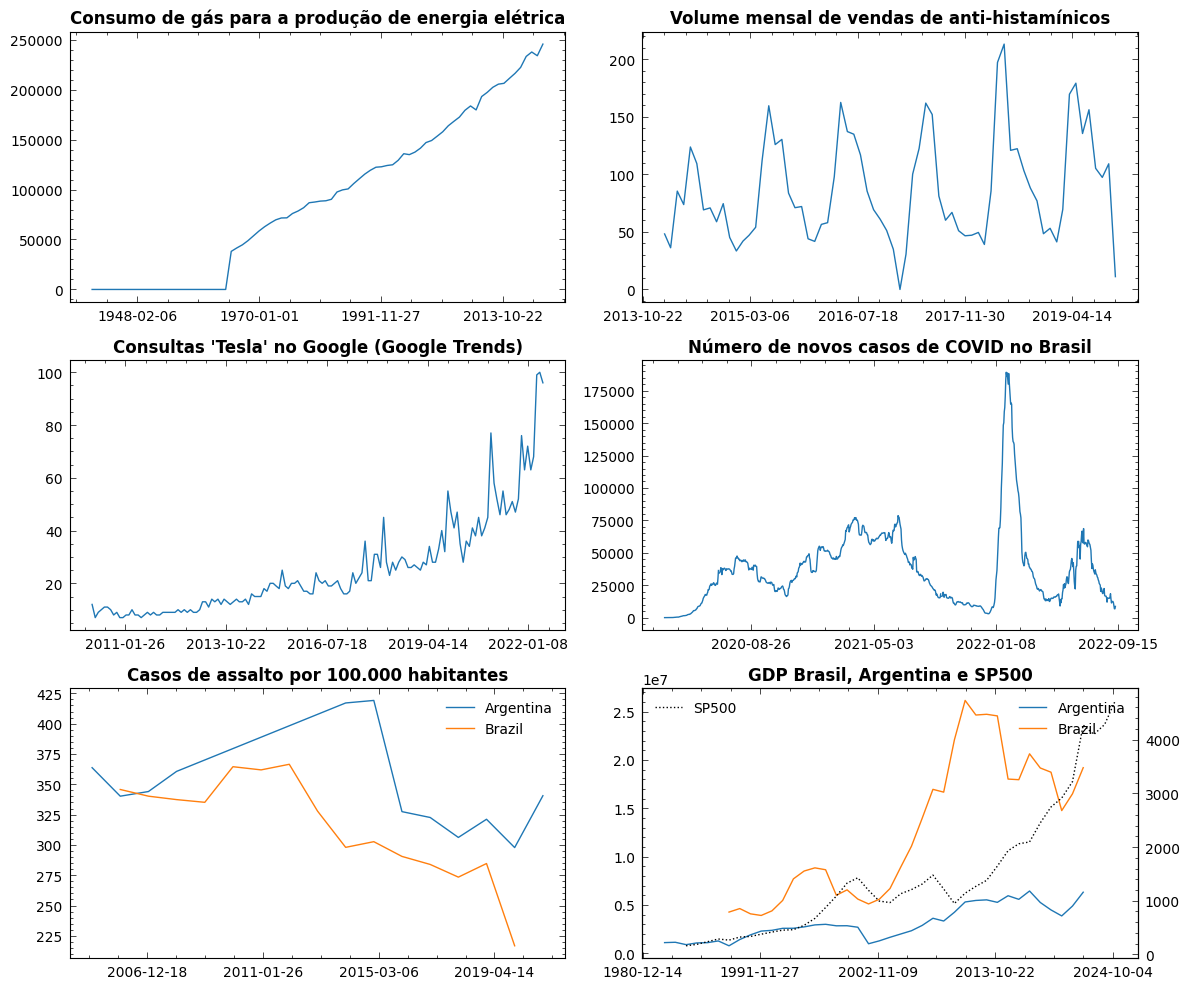

In [ ]:
#@markdown
datasets = pd.read_csv(path + 'datasets.csv', index_col=0)

fig, ax = plt.subplots(3,2,figsize=(12,10))

show_files = ['gas_consumption.csv', 'pharma_sales.csv', 'google_trends_tesla.csv', 'covid_brasil.csv' ]

title_files = ['Consumo de gás para a produção de energia elétrica',
               'Volume mensal de vendas de anti-histamínicos',
               "Consultas 'Tesla' no Google (Google Trends)",
               'Número de novos casos de COVID no Brasil' ]

for i, axis in enumerate(fig.axes):
  if i < 4:
    df = pd.read_csv(path + show_files[i],index_col=0,parse_dates=True)
    tspplot(df[ df.columns[0] ],title=title_files[i],ax=axis,nr_xticks=5)
  else:
    ax = fig.axes[4::]

import matplotlib.ticker as ticker

# fig, ax = plt.subplots(1,2,figsize=(12,3.5))

global_violence = pd.read_csv(course_path + '/data/global_violence.csv',index_col=0,parse_dates=True)
data = global_violence[ global_violence['Category'] == 'Serious assault'][['Country', 'VALUE']]
data = data.sort_index()
for country in data.Country.unique():
  ax[0].plot(data[ data.Country == country ].VALUE, label=country, lw=1)
ax[0].set_title('Casos de assalto por 100.000 habitantes')
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(5))
ax[0].legend()

GDP_BR_AR = pd.read_csv(course_path + '/data/GDP_BR_AR.csv',index_col=0,parse_dates=True)
sp500 = pd.read_csv(course_path + '/data/sp500.csv',index_col=0,parse_dates=True)

for country in GDP_BR_AR.country.unique():
  ax[1].plot(GDP_BR_AR[ GDP_BR_AR.country == country ]['GDP (Current USD)']/100000, label=country, lw=1)

ax2 = ax[1].twinx()
ax2.plot(sp500[sp500.index.year > 1983]['Adj Close'].resample('Y').mean(), 'k:', label='SP500', lw=1)

ax[1].set_title('GDP Brasil, Argentina e SP500')
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(5))

ax2.legend()
ax[1].legend()

plt.tight_layout()
plt.show()




**Figura 1. Diversos exemplos de séries temporais em diferentes áreas de domínio.**

De acordo com o seu objetivo você pode estar interessado em diferentes tarefas  aplicadas a uma série temporal:

1. Fazer previsões de valores futuros
1. Entender o mecanismo gerador da série
1. Descrever e comparar o comportamento da série
1. Procurar periodicidades e padrões relevantes
1. Identificar anomalias
1. Simular a série de dados

e, certamente, fazer previsões de valores futuros desempenha um papel bastante importante. Em todos os casos busca-se criar um modelo que se pretende útil para análise e aqui nos concentraremos unicamente em modelos auto-regressivos integrados de médias móveis (ARIMA) e de aprendizado de máquina supervisionado para previsões de valores futuros. Ambos são *modelos paramétricos* (possuem um número finito de parâmetros) e modelam as séries no *domínio do tempo* (diferentemente de modelos que empregam a frequência ou o espaço de estados), e estão entre os modelos mais amplamente aplicados na economia, finanças, engenharias e outras áreas.



## 2.1. Decomposição de séries temporais

A ideia de construir um modelo é a de criarmos uma simplificação útil dos dados e no caso de séries temporais o modelo de decomposição é o procedimento clássico.

Em geral decompomos uma série temporal em componentes onde cada um busca modelar um tipo de padrão ou comportamento da série:

* **Tendência**
* **Sazonalidade**
* **Resíduos**

A **tendência** apresenta o comportamento da série no longo prazo, o aumento ou diminuição dos valores da série no longo prazo, como o crescimento da temperatura global ano a ano. A componente **sazonalidade** apresenta o padrão sazonal da série, como mudanças que ocorrem com alguma periodicidade ao longo do tempo. É o caso dos acréscimos e decréscimos de temperatura que ocorrem ao longo das estações do ano, independentemente da elevação das temperaturas no longo prazo. Por último, os **resíduos**, apresentam o comportamento  estocástica, ou *aleatório* da série, e que não sabemos explicar. Correspondem, por exemplo, às diferenças de temperatura entre dois dias consecutivos da mesma estação causadas por inúmeros fatores como a maior presença de nuvens ou de raios solares naqueles dias. Essa componente também pode ser denominada de *erro aleatório* ou *ruído branco*.

Vários desses comportamentos podem ser observados nas séries de Figura 1, como a tendência linear crescente do consumo de gás para geração de energia, as sazonalidades anais da venda de anti-histamínicos etc.

Em geral, a tendência inclui uma outra componente denominada **ciclo**, mas que por simplicidade denominamos unicamente de tendência. Ciclos e mudanças sazonais são comportamentos bem diferentes nas séries temporais. A sazonalidade é um comportamento recorrente que se repete a intervalos fixos, regulares (a maior temperatura em certas estações do ano, o maior número de visitas em um site de entretenimento aos finais de semana). Já os ciclos são comportamentos recorrentes mas que ocorrem a intervalos não regulares. Vulcões e terremotos, por exemplo, têm um comportamento recorrente, mas não sabemos quando irão ocorrer, e uma série que represente as temperaturas ou o tremor em torno da cratera do Vulcão Eyjafjallajökull apresentará comportamentos repetitivos, mas que não são sazonais. O mesmo ocorre com os ciclos econômicos que alternam recessão e crescimento, e não sabemos quando irá ocorrer a próxima crise ou o estouro de uma *bolha* do mercado. Nas séries de Figura 1, por exemplo, podemos observar alguns 'ciclos' de séries financeiras (GDP e SP500) e das ondas de variantes da pandemia de COVID.





## **2.2. Séries temporais em Python**

Aquisição dos dados de uma série temporal pode ser feita na forma de dados tabulares. Em `Python`, o `Pandas` fornece suporte a vários tipos de formato de arquivos como `.csv`,`.xlsx`, `.json`, `.html`, `.hdf5` e `.sql` para a criação de um `DataFrame`.

In [ ]:
df = pd.read_csv(course_path + '/data/capea-consulta-cafe.csv')
df.head()

,Data,vista R$,vista US$
0,01/2014,288.98,119.88
1,02/2014,366.32,153.96
2,03/2014,437.24,187.79
3,04/2014,449.45,201.45
4,05/2014,429.28,193.22


O `Pandas` é uma biblioteca para manipulação de dados tabulares e oferece várias funcionalidades para a seleção e transformação dos dados.

In [ ]:
df[ df['vista R$'] > 1400 ][ ['Data', 'vista R$'] ]

,Data,vista R$
95,12/2021,1452.15
96,01/2022,1482.59
97,02/2022,1485.35


Um caso particularmente importante quando se trata de séries temporais trata-se da manipulação de datas.

In [ ]:
df.dtypes

Data          object
vista R$     float64
vista US$    float64
dtype: object

In [ ]:
# seleção errônea dos dados com o atributo Data no formato de caracteres (object)
df[ df['Data'] > '10/2023' ].head()

,Data,vista R$,vista US$
10,11/2014,460.96,180.61
11,12/2014,455.20,172.39
22,11/2015,469.39,124.29
23,12/2015,479.32,123.94
34,11/2016,556.74,166.83


In [ ]:
# seleção correta dos dados com o atributo Data no formato de datetime
df.Data = pd.to_datetime(df.Data)
df[ df['Data'] > '10/2023' ].head()

,Data,vista R$,vista US$
118,2023-11-01,888.00,181.31
119,2023-12-01,974.46,198.90
120,2024-01-01,1003.74,204.34


In [ ]:
df.Data = pd.to_datetime(df.Data)
df[ df['Data'].dt.year > 2023 ].head()

,Data,vista R$,vista US$
120,2024-01-01,1003.74,204.34


### 2.1.1. Time index

Em `Python`, muitas funções úteis para a manipulação de séries temporais como resample, gráficos e uso de outros pacotes, requerem que o atributo de tempo da série temporal esteja representado no índice dos dados.

In [ ]:
df.index = pd.to_datetime(df.Data)
df = df.drop(columns='Data')
df.head()

,vista R$,vista US$
Data,,
2014-01-01,288.98,119.88
2014-02-01,366.32,153.96
2014-03-01,437.24,187.79
2014-04-01,449.45,201.45
2014-05-01,429.28,193.22


In [ ]:
# resample dos dados por ano
#
df_year = df.resample('Y').mean()
df_year.head()

,vista R$,vista US$
Data,,
2014-12-31,418.572500,177.984167
2015-12-31,451.494167,137.497500
2016-12-31,494.522500,142.853333
2017-12-31,465.690833,146.050833
2018-12-31,435.646667,120.087500


In [ ]:
pd.infer_freq(df.index), pd.infer_freq(df_year.index)

('MS', 'A-DEC')

### 2.1.2. Gráficos

Gráficos de séries de dados são fundamentais para explorar e entender o comportamento dos dados e podem ser obtidos com bibliotecas como `matplotlib` ou `seaborn`. Um índice do tipo `datetime` permite que identificar os dados como uma série temporal e formatar a escala de tempo dos gráficos.

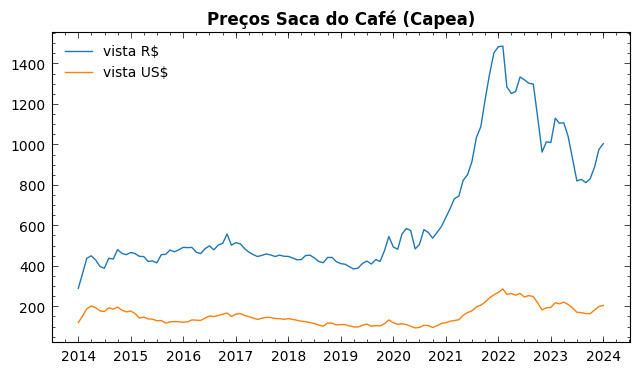

In [ ]:
fig, ax = plt.subplots()

ax.plot(df,label=['vista R$','vista US$'])

ax.set_title('Preços Saca do Café (Capea)')
ax.legend()

plt.show()

### 2.1.3. Decompondo uma série temporal

O principal pacote para modelos estatísticos de séries de dados em `Python` é o `statsmodel`, e a função `seasonal_decompose()` permite decompor uma série em suas componentes de tendência, sazonalidade e resíduos.

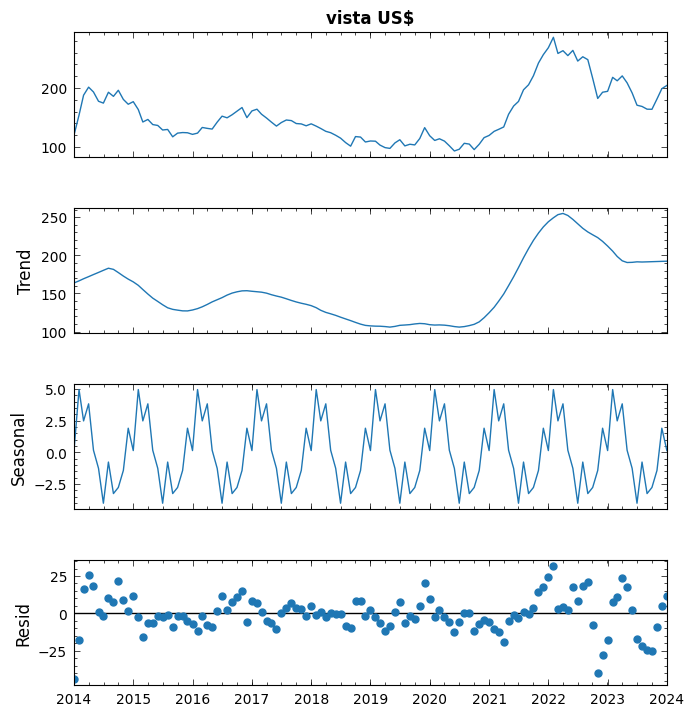

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['vista US$'], model='additive', extrapolate_trend=1)

fig = result.plot()
fig.set_size_inches((7, 8))

plt.show()



In [ ]:
df_compose = pd.DataFrame()

df_compose['trend'] = result.trend
df_compose['seasonal'] = result.seasonal
df_compose['resid'] = result.resid

df_compose['compose'] = df_compose.sum(axis=1)
df_compose.head()

,trend,seasonal,resid,compose
Data,,,,
2014-01-01,163.774583,0.142035,-44.036618,119.88
2014-02-01,166.537917,4.960345,-17.538262,153.96
2014-03-01,169.301250,2.486304,16.002446,187.79
2014-04-01,172.064583,3.833470,25.551946,201.45
2014-05-01,174.827917,0.168887,18.223196,193.22


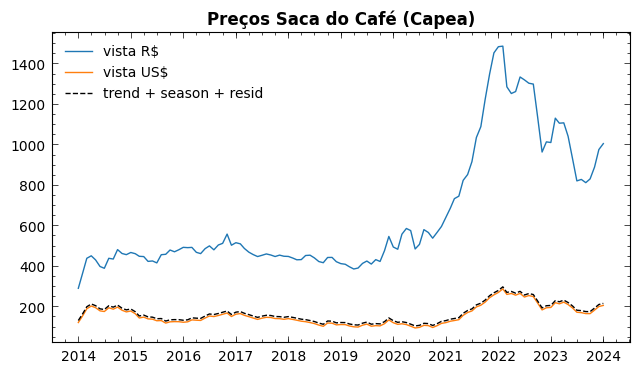

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,4))

ax.plot(df,label=['vista R$','vista US$'])
ax.plot(df_compose['compose']+10,color='k',linestyle='dashed',label='trend + season + resid')

ax.set_title('Preços Saca do Café (Capea)')
ax.legend()

plt.show()

## 2.3. Séries aditivas e multiplicativas

 A depender da natureza da série as componentes de tendência, sazonalidade e resíduo podem ser combinadas de forma aditiva ou multiplicativa, isto é:

$$ Y_t = T_t + S_t + R_t $$

para modelos aditivos, ou:

$$ Y_t = T_t \times S_t \times R_t $$

para modelos multiplicativos, sendo $Y_t$ a série observada e $T_t, S_t, R_t$ respectivamente as componentes de tendência, sazonalidade e resíduo.

Idealmente você pode ter em mente que séries aditivas apresentam valores que, embora apresentem variações, têm uma variação limitada ao longo do tempo. Já séries multiplicativas, em geral, apresentam um comportamento explosivo, ou exponencial. De qualquer modo, lembre-se que os modelos são simplificações que buscam ser úteis, e uma série, por exemplo a atividade solar a cada mês, não tem qualquer obrigação de se comportar de forma aditiva ou multiplicativa, e nem sempre é muito simples identificar se uma série é aditiva ou multiplicativa.



## 2.4. Estacionariedade  

Decompor uma série já traz informações bastante úteis, como a tendência de seus valores futuros, padrões sazonais e seu grau de incerteza. Mas na maior parte dos casos estamos interessados em fazer previsões mais assertivas dos valores futuros.

Para isso, a maior parte dos modelos assume que a série que se deseja prever é uma série *estacionária*. Uma série  estacionária, é uma série em que as estatísticas dos dados, isto é, média, variância e covariância *não mudam ao longo do tempo*. A *estacionariedade no sentido amplo* significaria a ausência completa de tendência e sazonalidade da série. Mas, em geral, é suficiente e mais comum a *estacionariedade no sentido restrito*, podendo haver mudanças das estatísticas em algum momento (como as sazonalidades) mas não *ao longo do tempo*.



In [ ]:
no_stacionary_avg = pd.read_csv(course_path + '/data/no_stacionary_avg.csv',index_col=0,parse_dates=True)
# display(no_stacionary_avg.head())

no_stacionary_var = pd.read_csv(course_path + '/data/no_stacionary_var.csv',index_col=0,parse_dates=True)
# display(no_stacionary_var.head())

stacionary = pd.read_csv(course_path + '/data/stacionary.csv',index_col=0,parse_dates=True)
# display(stacionary.head())

In [ ]:
#@markdown `PLOT` e `ADF`
def PLOT(df,ADF_result):

  fig, ax = plt.subplots(1,2,figsize=(12,3.5))
  ax[0].plot(df,label='Série',alpha=0.5,lw=1)
  # plt.setp(ax[0].get_xticklabels(), fontsize=9)
  ax[0].tick_params(axis='x', labelsize=9)
  ax[0].plot(df.rolling(ADF_result[2]).mean(),label='Média Móvel (' + str(ADF_result[2]) + ')',c='k')

  if ADF_result[1] < 0.05:
    ax[0].set_title('Série ADF estacionária, p-value = ' + str(np.round(ADF_result[1],4)))
  else:
    ax[0].set_title('Série não ADF estacionária, p-value = ' + str(np.round(ADF_result[1],4)))

  ax[0].legend(loc='upper left')

  grouped_means = [df['values'][i:i+ADF_result[2]].mean() for i in range(0, len(df), ADF_result[2])]
  grouped_var = [df['values'][i:i+ADF_result[2]].var() for i in range(0, len(df), ADF_result[2])]

  # ax[1].bar(range(len(grouped_means)), grouped_means, width=0.5, label='Médias', alpha=0.8)
  # ax[1].bar(range(len(grouped_var)), grouped_var, width=0.5, label='Variância', alpha=0.8)
  ax[1].plot(range(len(grouped_means)), grouped_means, label='Médias',alpha=0.8)
  ax[1].plot(range(len(grouped_var)), grouped_var, label='Variância',alpha=0.8, linestyle='dashed')

  ax[1].set_title('Médias e variância ao longo do tempo')
  ax[1].legend(loc='upper left')

  plt.tight_layout()
  plt.show()

  return

from statsmodels.tsa.stattools import adfuller, kpss

def ADF(df,verbose=False):
  result = adfuller(df) # ,autolag=None,maxlag=60)
  if verbose:
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('ADF lags: %d' % result[2])

    if result[1] < 0.05:
      print('Série é ADF estacionária')
    else:
      print('Série não ADF é estacionária')

  return result



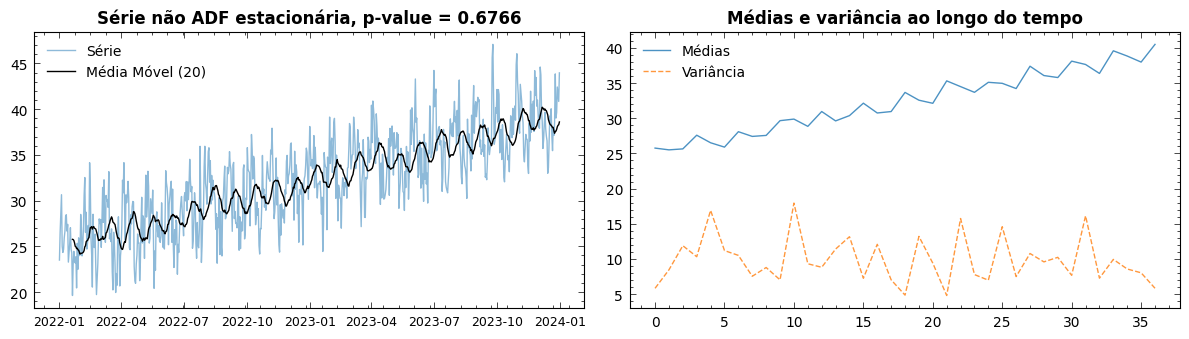

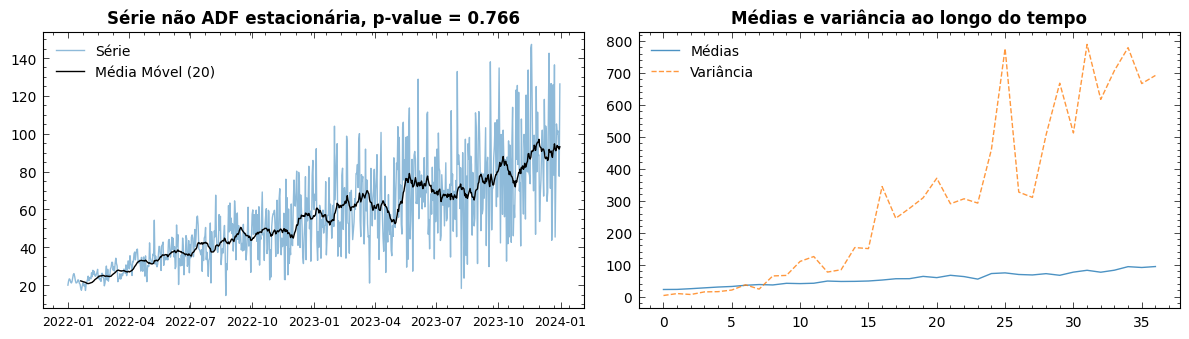

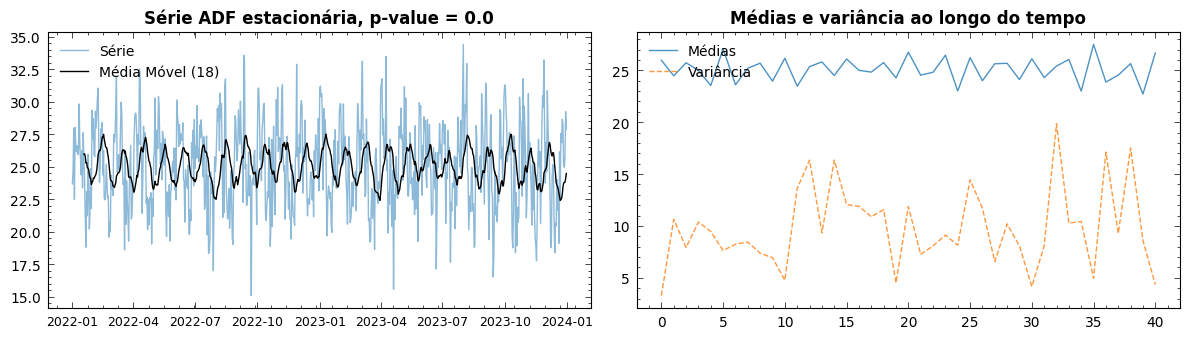

In [ ]:
PLOT(no_stacionary_avg, ADF(no_stacionary_avg))
PLOT(no_stacionary_var, ADF(no_stacionary_var))
PLOT(stacionary, ADF(stacionary))

Há vários testes estatísticos para verificar a estacionariedade de uma série temporal, mas os testes mais comuns são o teste **Augmented Dickey Fuller (“ADF”)** e o teste **Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”)** e que, basicamente, verificam a presença de tendência na série e  entendimento do domínio e a análise exploratória dos dados são essenciais para uma interpretação adequada desses testes. Os gráficos anteriores ilustram diferentes casos de  estacionariedade e não estacionariedade com os respectivos p-values do teste ADF.

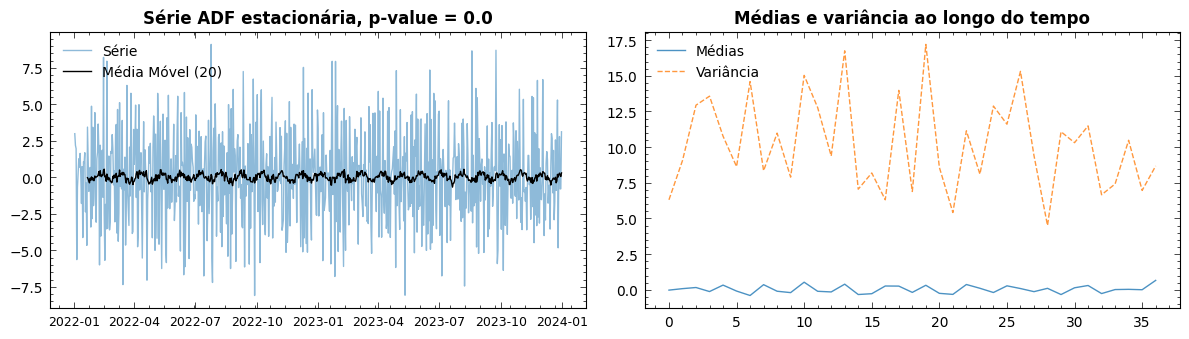

In [ ]:
PLOT(no_stacionary_avg.diff().dropna(), ADF(no_stacionary_avg.diff().dropna()))

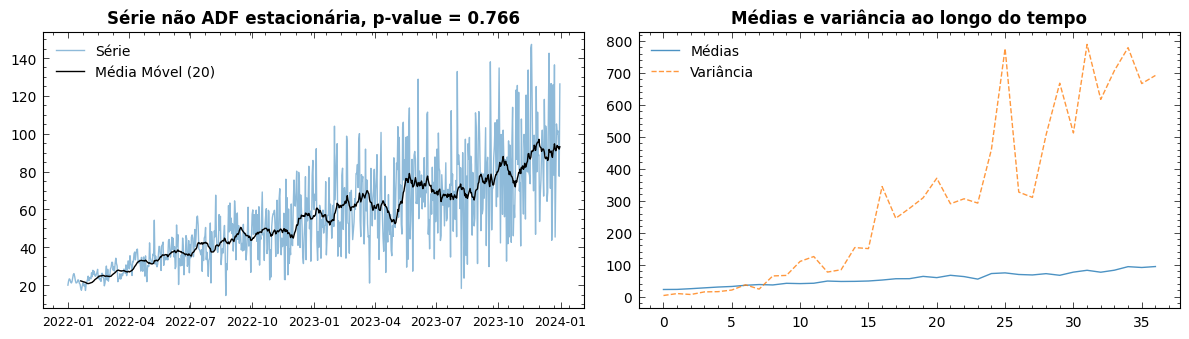

In [ ]:
PLOT(no_stacionary_var, ADF(no_stacionary_var))

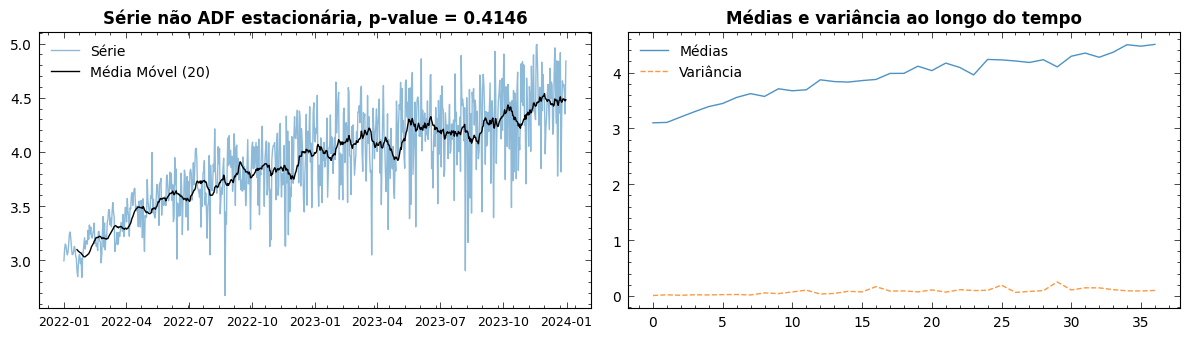

In [ ]:
PLOT(no_stacionary_var.apply(lambda x: np.log(x)), ADF(no_stacionary_var.apply(lambda x: np.log(x))))

Tanto no ADF como no KPSS teste, a hipótese nula (estacionariedade) é rejeitada para $\text{p-value} > 0.05$. Assim, **para $\text{p-value} < 0.05$, diremos que a série é estacionária**.

In [ ]:
no_stacionary_varlog = no_stacionary_var.copy() + 100
no_stacionary_varlog['values'] = np.log(no_stacionary_varlog['values'])
no_stacionary_varlog

,values
2022-01-01,4.787492
2022-01-02,4.806001
2022-01-03,4.815080
2022-01-04,4.812198
2022-01-05,4.802021
...,...
2023-12-27,5.297462
2023-12-28,5.306180
2023-12-29,5.263597
2023-12-30,5.179173


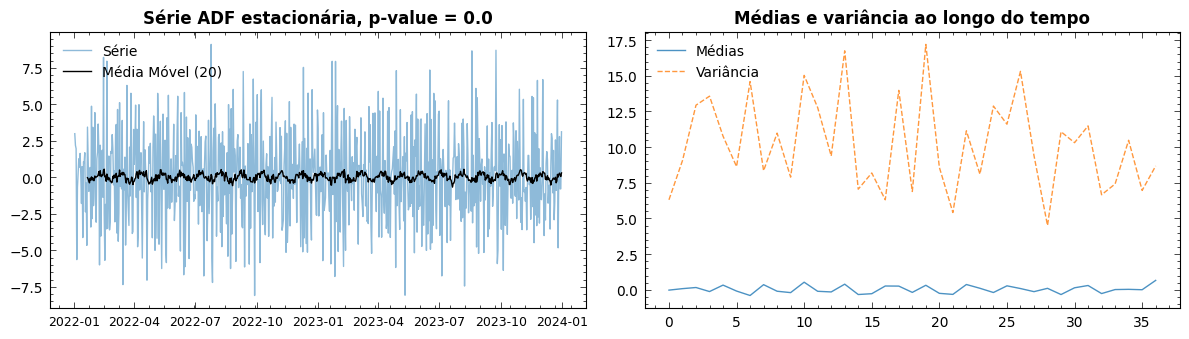

In [ ]:
PLOT(no_stacionary_avg.diff().dropna(), ADF(no_stacionary_avg.diff().dropna()))

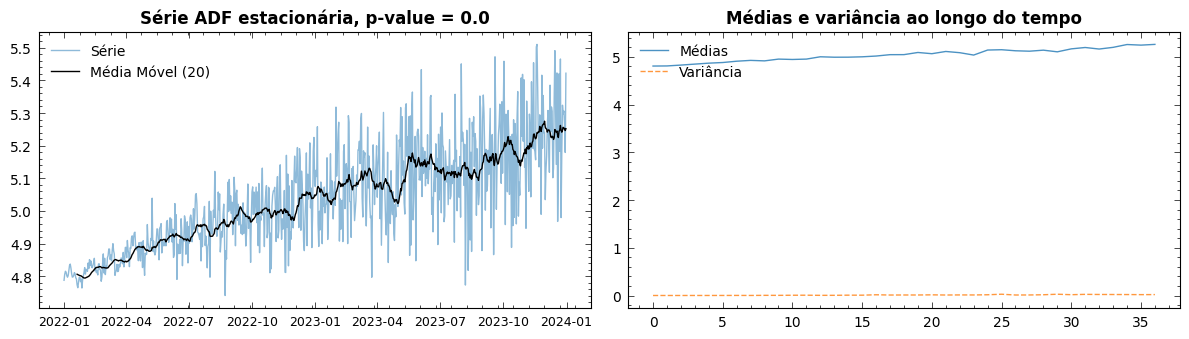

In [ ]:
PLOT(no_stacionary_varlog.dropna(), ADF(no_stacionary_varlog.diff().dropna()))

## 2.5. Sazonalidade

A inspeção visual das séries desempenha um papel fundamental na identificação de sazonalidades, como também da estacionariedade apesar dos testes disponíveis. Gráficos de agrupamentos com os valores médios por dia, mês etc. são bastantes empregados e constituem a base de muitos modelos de sazonalidade.

In [ ]:
# Criando uma série de periodicidade anual
date_range = pd.date_range(start='2021-01-01', periods=4*12, freq='M')

# Repetindo o padrão mensal (de janeiro a dezembro) por 3 anos
seasonal_pattern = np.sin(np.linspace(0, 2*np.pi, 12))

# Repetindo o padrão sazonal para cada ano
values = np.tile(seasonal_pattern, 4)
values = 10*values + 5*np.random.sample(len(values))

time_series = pd.DataFrame({'Value': values},index=date_range)

In [ ]:
# agregando os valores
group_month = pd.DataFrame(time_series.groupby([time_series.index.year,time_series.index.month]).mean()).reset_index()
group_month.columns = ['year','month','values']


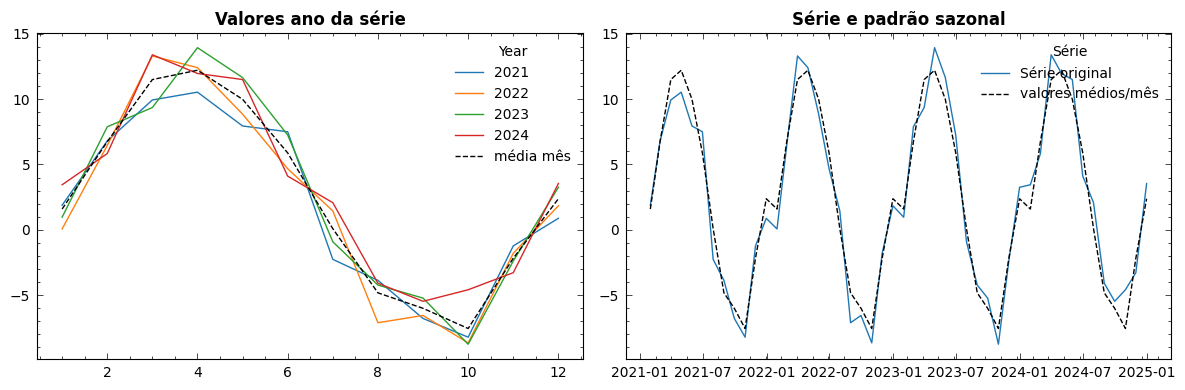

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

for y in group_month.year.unique():
 ax[0].plot(group_month[ group_month.year == y ].month,group_month[ group_month.year == y ]['values'],label=y)

ax[0].plot(time_series.index.month.unique(),time_series.groupby([time_series.index.month]).mean(),
           'k--',label='média mês')
ax[0].set_title('Valores ano da série')
ax[0].legend(title='Year',loc='upper right')

ax[1].plot(time_series,label='Série original')
ax[1].plot(time_series.index,np.tile(time_series.groupby([time_series.index.month]).mean().values.flatten(),4),
           'k--',label='valores médios/mês')
ax[1].set_title('Série e padrão sazonal')
ax[1].legend(title='Série',loc='upper right')

plt.tight_layout()
plt.show()

### 2.5.1. Peridiograma

Apesar da importância e predominância da inspeção visual, o **peridiograma** pode ser uma ferramenta bastante útil e mais adiante introduziremos os gráficos autocorrelação que também nos ajudam a identificar sazonalidades.

O peridiograma apresenta a distribuição das frequências em um sinal ao longo do tempo e as frequências mais presentes podem ser empregadas para identificar as sazonalidades presentes na série.

$$ P_i = \frac{\text{Total de Períodos}}{freq_i} $$

onde, $P_i$ é a periodicidade da frequência $freq_i$. Pode haver inúmeras frequências, mas podemos nos limitar as mais predominantes (1, 2 ou 3 mais presentes).

,frequencies,spectrum,periods
24,24.0,2.960242,30.416667
104,104.0,1.515986,7.019231
25,25.0,0.723724,29.200000
105,105.0,0.305413,6.952381
23,23.0,0.188924,31.739130


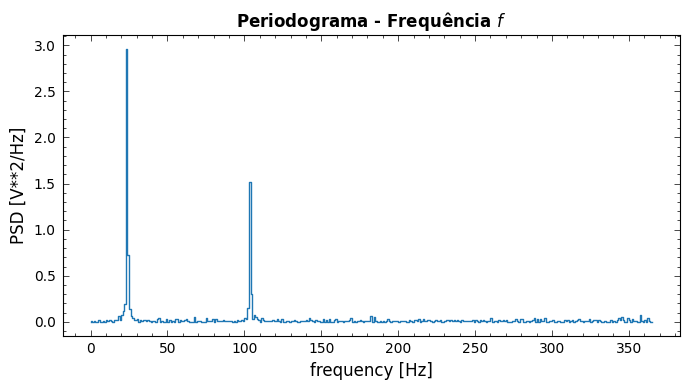

In [ ]:
from scipy import signal

fig, ax = plt.subplots(1,1, figsize=(7,4))

frequencies, spectrum = signal.periodogram(stacionary['values'],fs=len(stacionary))

ax.step(frequencies, spectrum)

ax.set_title('Periodograma - Frequência $f$')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')

dfft = pd.DataFrame()
dfft['frequencies'], dfft['spectrum'] = frequencies, spectrum
dfft['periods'] = len(stacionary) / dfft['frequencies']
display(dfft.sort_values('spectrum',ascending=False).head())

plt.tight_layout()
plt.show()




## 2.6. Diferenciação e Log: eliminando a tendência e sazonalidade

Um dos métodos mais simples para se reduzir a tendência de uma série temporal é construir uma nova série por **diferenciação**. Nesta nova série o valor no intervalo de tempo atual é calculado como a diferença entre o valor original e o valor no intervalo de tempo anterior.

$$ \Delta y_t = y_t - y_{t-1} $$  

In [ ]:
ts = no_stacionary_avg
ts['y'] = ts['values']
ts['y.diff()'] = ts['y'].diff()

ts['y_cumsum()'] = ts['y'].diff()
ts.at['2022-01-01','y_cumsum()'] = ts.iloc[0]['y']
ts['y_cumsum()'] = ts['y_cumsum()'].cumsum()

ts.head()

,values,y,y.diff(),y_cumsum()
2022-01-01,23.497938,23.497938,NaN,23.497938
2022-01-02,26.489463,26.489463,2.991525,26.489463
2022-01-03,28.679608,28.679608,2.190145,28.679608
2022-01-04,30.644750,30.644750,1.965142,30.644750
2022-01-05,25.008379,25.008379,-5.636372,25.008379


In [ ]:
no_stacionary_avg.head()

,values,y,y.diff(),y_cumsum()
2022-01-01,23.497938,23.497938,NaN,23.497938
2022-01-02,26.489463,26.489463,2.991525,26.489463
2022-01-03,28.679608,28.679608,2.190145,28.679608
2022-01-04,30.644750,30.644750,1.965142,30.644750
2022-01-05,25.008379,25.008379,-5.636372,25.008379


In [ ]:
result = adfuller(ts['y']) # ,autolag=None,maxlag=60)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('ADF lags: %d' % result[2])

if result[1] < 0.05:
  print('Série é ADF estacionária')
else:
  print('Série não ADF é estacionária')

ADF Statistic: -1.192998
p-value: 0.676601
ADF lags: 20
Série não ADF é estacionária


In [ ]:
pvalue_y = np.round(result[1],4)

In [ ]:
result = adfuller(ts['y.diff()'].dropna()) # ,autolag=None,maxlag=60)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('ADF lags: %d' % result[2])

if result[1] < 0.05:
  print('Série é ADF estacionária')
else:
  print('Série não ADF é estacionária')

ADF Statistic: -15.441592
p-value: 0.000000
ADF lags: 20
Série é ADF estacionária


In [ ]:
pvalue_y_diff = np.round(result[1],4)

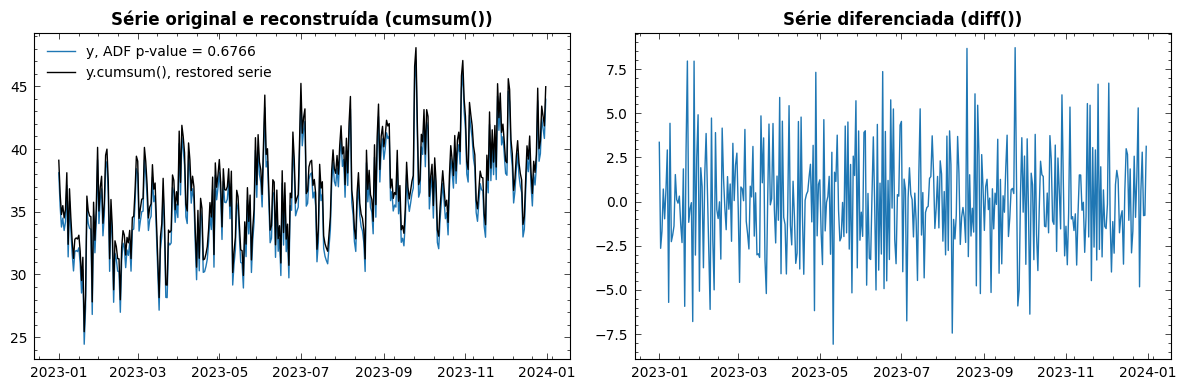

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(ts[ts.index.year >= 2023]['y'],label='y, ADF p-value = ' + str(pvalue_y), lw=1)
ax[0].plot(ts[ts.index.year >= 2023]['y_cumsum()']+1,'k',label='y.cumsum(), restored serie', lw=1)
ax[0].set_title('Série original e reconstruída (cumsum())')
ax[0].legend()

ax[1].plot(ts[ts.index.year >= 2023]['y.diff()'],label=['y.diff(), ADF p-value = ' + str(pvalue_y_diff)])
ax[1].set_title('Série diferenciada (diff())')

plt.tight_layout()
plt.show()

A diferenciação acima é de ordem 1 e diferenciações maiores podem ser aplicadas para, por exemplo, eliminar uma tendência polinominal. Para tendências exponenciais pode ser necessário aplicar, do mesmo modo, a transformação *logarítimica* da série (tornando-a linear) antes de se aplicar a diferenciação.

## 2.7. Resíduos

Os pressupostos do modelo ARIMA incluem a estacionariedade da série temporal (ou a estacionariedade por diferenciação), mas também a independência dos resíduos e a normalidade dos resíduos.

O termo resíduo é ser empregado para designar a diferença entre os valores reais e o ajuste obtido da série por algum modelo e consiste em uma componente *não explicada* série.

Essa diferença pode ser medida de diversas formas, mas ao final todas refletem as diferenças da série real $Y_t$ e os valores estimados $\hat Y_t$ que queremos minimizar. Por serem muito empregadas algumas dessas medidas recebem nomes especiais:

* Erro Médio Absoluto (*Mean Absolute Error*), $MAE = \frac{1}{n} \sum | Y_t - \hat Y_t |$

* Erro Médio Quadrático (*Mean Square Error*), $MSE = \frac{1}{n} \sum ( Y_t - \hat Y_t )^2$

* Raiz do Erro Médio Quadrático (*Root Mean Square Error*), $RMSE = \sqrt{ \frac{1}{n} \sum ( Y_t - \hat Y_t )^2 } $

* Erro Percentual Absoluto Médio (*Mean Absolute Percentage Error*), $MAPE = \frac{1}{n} \sum | \frac{Y_t - \hat Y_t}{Y_t} |$

Todas medidas que podem ser fácil e diretamente calculadas ou pode-se empregar algum pacote.



In [ ]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tools.eval_measures as eval_measures

def error_measures(y, y_pred):

    mae = np.mean(np.abs(y_pred - y))                  # MAE
    mse = np.mean((y_pred - y)**2)                     # MSE
    rmse = eval_measures.rmse(y, y_pred, axis=0)       # RMSE from statsmodels
    # rmse = np.mean((y_pred - y)**2)**.5              # RMSE
    mape = np.mean(np.abs(y_pred - y)/np.abs(y))       # MAPE

    metrics = {'MSE':mse, 'MAE': mae, 'RMSE':rmse, 'MAPE':mape}

    for key, value in metrics.items():
      print(f'{key}: \t {value:.4f}')

    return metrics

In [ ]:
result = seasonal_decompose(stacionary, model='additive')

non_NA = pd.merge(stacionary, result.trend, how='inner', left_index=True, right_index=True).dropna().index # exclui valores nulos das previsões

y = stacionary.loc[non_NA]['values']
y_pred = result.trend.loc[non_NA] + result.seasonal.loc[non_NA]

_ = error_measures(y,y_pred)

MSE: 	 3.6922
MAE: 	 1.5335
RMSE: 	 1.9215
MAPE: 	 0.0628


Mas além de buscar minimizar o erro, ou resíduos, queremos que seus valores sejam independentes, no sentido de não estarem correlacionados, e que apresentem uma distribuição normal.

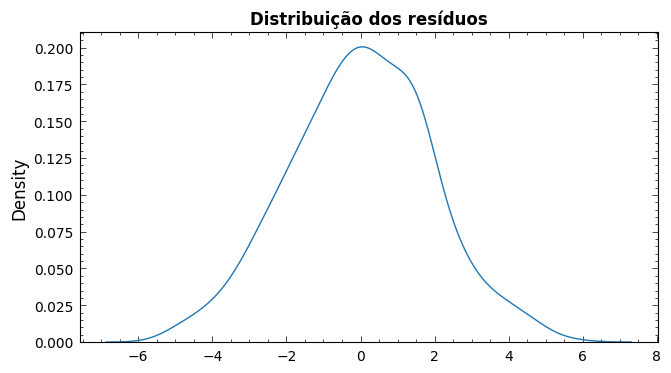

In [ ]:
sns.kdeplot(y - y_pred)

plt.title('Distribuição dos resíduos')
plt.show()

A normalidade dos resíduos pode ser verificada através de um gráfico de distribuição ou do tipo *qqplot*, o que é mais comum que o uso de testes de hipótese de normalidade. Para independência dos resíduos pode-se empregar um gráfico de autocorrelação dos resíduos. Veremos esse gráfico mais adiante como também uma função `plot_diagnostics()` do `statsmodels` que agrega todos esses gráficos para uma melhor análise dos resíduos.

# **3. Modelos autoregressivos**

 A ideia principal dos modelos autoregressivos, incluindo o ARIMA, consiste em modelar a dependência serial dos dados, uma vez que, na maioria das séries, observa-se que os valores recentes estão correlacionados com seus valores passados e que a força dessa dependência diminui quando considerados valores mais distantes no tempo. Assim, é razoável pensar que o valor de amanhã das vendas de uma safra ou do volume de chuvas está correlacionado com os mesmos valores observados ontem, ou no dia anterior, e que essa correlação diminui conforme nos afastamos no tempo.



## 3.1. Modelos de regressão e autoregressão

Modelos de regressão se baseiam em variáveis independentes para prever a variável dependente, os modelos de autoregressão usam os próprios valores passados da variável dependente para fazer previsões futuras. Para séries temporais, em geral, faz mais sentido empregarmos a forma autoregressiva que empregar o tempo (que seria única variável independente em uma única série de dados). Entretanto, em ambos os casos o cálculo dos coeficientes pode ser feito do mesmo modo (em geral um método de mínimos quadrados).




In [ ]:
co2 = pd.read_csv(path + 'co2.csv',index_col=0,parse_dates=True)

co2['CO2_t-1'] = co2.CO2.shift()
co2['CO2_t-2'] = co2.CO2.shift().shift()
co2 = co2.dropna()
co2.head()


,time,CO2,CO2_t-1,CO2_t-2
Date,,,,
1981-07-01,2,340.32,342.08,342.74
1981-08-01,3,338.26,340.32,342.08
1981-09-01,4,336.52,338.26,340.32
1981-10-01,5,336.68,336.52,338.26
1981-11-01,6,338.19,336.68,336.52


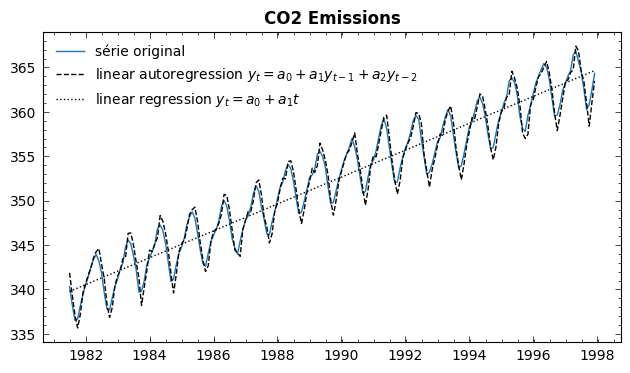

In [ ]:
import statsmodels.api as sm

X = co2[['CO2_t-1','CO2_t-2']]
y = co2[['CO2']]

X = sm.add_constant(X)
y_autoregression = sm.OLS(y, X).fit().predict()

X = co2[['time']]

X = sm.add_constant(X)
y_regression = sm.OLS(y, X).fit().predict()

plt.plot(co2.CO2,label='série original')
plt.plot(co2.index,y_autoregression, 'k--', label='linear autoregression $y_t = a_0 + a_1 y_{t-1} + a_2 y_{t-2}$')
plt.plot(co2.index,y_regression, 'k:', label='linear regression $y_t = a_0 + a_1 t$')

plt.legend(loc='upper left')
plt.title('CO2 Emissions')

plt.show()

## 3.2. Modelo ARIMA

Existem vários tipos de modelos, empregando diferentes princípios, para análise e previsões de séries temporais. O modelo ARIMA (Autorregressivos Integrados de Médias Móveis), é um modelo de análise estatística amplamente utilizado para modelar séries temporais estacionárias e não estacionárias, e constituir a base de modelos mais complexos (ARIMAX, VARIMAX, SARIMAX, ARCH, GARCH etc. envolvendo variáveis exógenas, sazonalidades e volatilidade de séries temporais). O ARIMA é, portanto, um modelo fundamental.

O modelo ARIMA consiste nos seguintes componentes:

* $AR (p)$ : Termo autoregressivo que incorpora a dependência entre uma observação e uma série de observações defasadas até a ordem $p$, o que pode ser escrito do seguinte modo:

$$Y_t=\phi_0 + \phi_1Y_{t-1}+ \phi_2Y_{t-2}+...+ \phi_pY_{t-p} + \epsilon_t,$$

onde $\epsilon_t$ é o erro do modelo.

* $I (d)$: Termo integrado que envolve diferenciar na ordem $d$ os dados da série temporal para torná-los estacionários.

$$W_t={\Delta^d Y_t} = Y_t - Y_{t-d}$$ e portanto,
$$ Y_t =  W_t + Y_{t-d}$$

* $MA (q)$: Termo de média móvel que leva em conta a dependência entre uma observação e um erro residual de um modelo de média móvel de ordem $q$.

$$Y_t=\mu + e_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} +...+ \theta_q \epsilon_{t-q} ,$$

onde $\mu$ é a média da série.

Tanto o modelo $AR$ como o modelo $MA$ são conceitualmente e podem ser calculados como uma regressão linear do valor atual da série, respectivamente sobre seus valores passados ($AR$) e os termos de erro com relação à média móvel ($MA$).
Ao final o modelo ARIMA completo pode ser escrito como:

$$W_t=\underbrace{\Delta^d Y_t}_{I(d)}$$

$${W_t} = \underbrace{\phi_0+ \phi_1 W_{t-1}+ \phi_2 W_{t-2}+...+\phi_p  W_{t-p}}_{AR(p)} +\underbrace{\epsilon_t + \theta_1 \epsilon_{t-1}+ \theta_2 \epsilon_{t-2}+...+ \theta_q \epsilon_{t-q}}_{MA(q)}, $$

$$ Y_t =  W_t + Y_{t-d}$$

Assim, o modelo ARIMA é a junção de modelos que podem também ser empregados de forma independente como segue.

<br>

\begin{array}{c c c}
\hdashline
\text{Model}&\text{ARIMA(p,q,d)}&\text{Tipo de Série}\\ \hdashline
AR(p) & ARIMA(p, 0, 0) & \text{estacionária} \\
MA(q) & ARIMA(0, 0, q) & \text{estacionária} \\
ARMA(p,q) & ARIMA(p, 0, q) & \text{estacionária} \\
ARIMA(p, d, q) & ARIMA(p, d, q) & \text{não estacionária} \\   \hdashline
\end{array}

<br>

E em todos os casos como vimos assume-se a independência e a normalidade dos resíduos da série.



### 3.2.1. Exemplo 1
Considerando a série $Y_t$ estacionária podemos considerar os seguintes modelos de ordem 1:

<br>

\begin{array}{c c }
\hdashline
\text{Modelo}&\text{ARIMA(p,q,d)}\\ \hdashline
AR(1) \space \text{ou} \space ARIMA(1,0,0) & Y_t=\phi_0 + \phi_1Y_{t-1} + \epsilon_t  \\
I(1) \space \text{ou} \space ARIMA(0,1,0) & Y_t= Y_{t-1} + \epsilon_t    \\
MA(1) \space \text{ou} \space ARIMA(0,0,1) & Y_t= \epsilon_t + \theta_1 \epsilon_{t-1}  \\
ARMA(1,1) \space \text{ou} \space ARIMA(1,0,1) & Y_t=\phi_0 + \phi_1Y_{t-1} + \epsilon_t + \theta_1 \epsilon_{t-1}  \\
  \hdashline
\end{array}

<br>



### 3.2.2. Exemplo 2

Considerando a série $Y_t$ estacionária para a diferenciação de ordem 1, podemos construir a série estacionária:

$$W_t = Y_t-Y_{t-1}$$

e, então, o modelo:


<br>

\begin{array}{c c }
\hdashline
\text{Modelo}&\text{ARIMA(p,q,d)}\\ \hdashline
ARIMA(1,1,1) & W_t=\phi_0 + \phi_1W_{t-1} + \epsilon_t + \theta_1 \epsilon_{t-1}    \\
  \hdashline
\end{array}

<br>

Em que é ajustado um modelo ARMA(1,1) à série diferenciada $W_t$.



### 3.2.3. Exemplo 3

 Modelos de *suavização*, uma outra técnica bastante empregada em séries temporais, também podem ser derivados de modelos ARIMA como o modelo básico de suavização (ARIMA(0,1,1)), o modelo de *Holt Amortecido* (ARIMA(0,1,2)) e o método linear de Holt (ARIMA(0,2,2)). E o modelo ARIMA Sazonal, SARIMA(p,d,q)(P,D,Q), consiste em um modelo ARIMA em que a componente sazonal é também modelada do mesmo modo com os parâmetros P, D, Q.

## 3.3. Autocorrelação e autocorrelação parcial

A correlação de duas variáveis  $x, y$  refere-se à sua dependência linear e é dada por:

$$ \rho(x,y) = \frac{cov(x,y)}{\sqrt{var(x)var(x)}} $$

Em séries temporais, nos referimos à *autocorrelação* à correlação entre valores da mesma série para intervalos de tempo diferentes e, por exemplo a correlação do valor atual com o valor do instante anterior da série é dado por:

$$ \rho(x_t,x_{t-1}) = \frac{cov(x_t,x_{t-1})}{\sqrt{var(x_t)var(x_{t-1})}} $$

A função ACF (*Autocorrelation Function*) fornece os valores de autocorrelação para diferentes defasagens de valores ($x_{t-1}, x_{t-2},...$) e fornece uma boa estimativa para os valores $q$ do modelo AR. A função ACF considera todos os valores intermediários, isto é, a correlação de $x_t$ e $x_{t-k}$ inclui cadeia de dependência de todos os têrmos entre os dois valores. A função PACF (*Partial Autocorrelation Function*) estima os valores de autocorrelação para diferentes defasagens de valores ($x_{t-1}, x_{t-2},...$) somente para o último elemento, excluindo as dependências anteriores. Ela fornece uma boa estimativa para os valores $p$ do modelo AR.

<br>

\begin{array}{c c c c}
\hdashline
\text{Função} & MA(q) & AR(p) & ARMA(p,q) \\ \hdashline
ACF & \text{Desprezível após } q & \text{Decaimento}^1 & \text{Decaimento}^1 \text{após } q \\
PACF & \text{Decaimento}^1 & \text{Desprezível após } p  & \text{Decaimento}^1 \text{após } p \\ \hdashline
\end{array}

$^1$ *Decaimento tipo exponencial ou sinusoide*

<br>

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_ts_acf_pacf(ts,model_name):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,3.5))

  ax1.plot(ts,linestyle='solid',alpha=1,lw=1)
  ax1.title.set_text('Série ' + model_name)
  plot_acf(ts, ax=ax2, title='ACF ' + model_name)
  y=plot_pacf(ts, ax=ax3, title='PACF ' + model_name)

  plt.tight_layout()
  plt.show()
  return

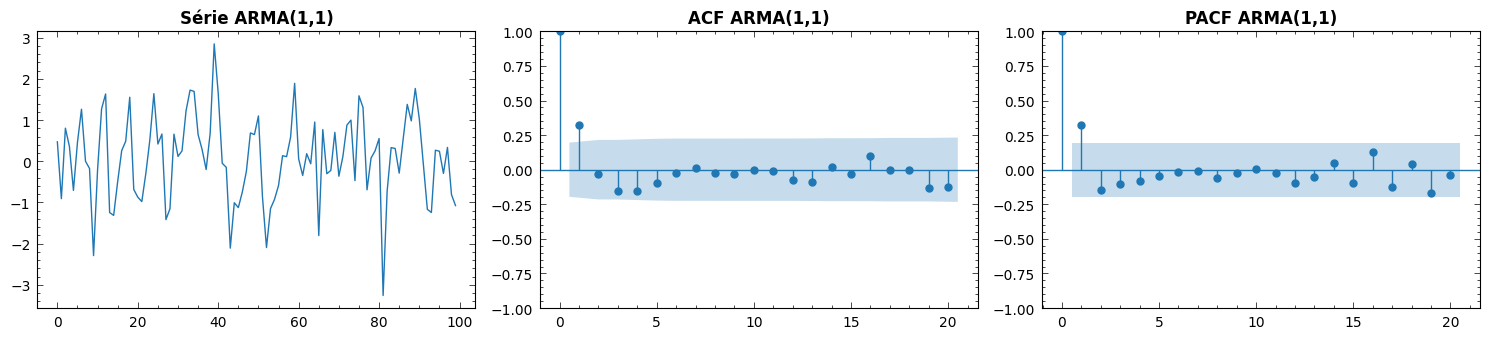

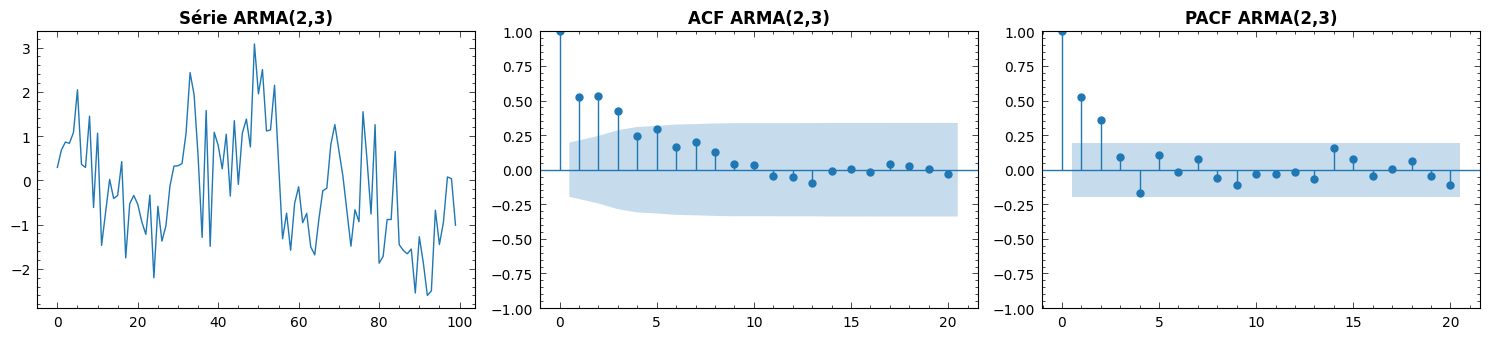

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(1234)

model_name = 'ARMA(1,1)'
ar = np.array([1,-0.3,0,0,0,0]) # list ar_coefs has the form [1, -a_1, -a_2, ..., -a_p]
ma = np.array([1,0.3,0,0,0,0])  # list ma_coefs has the form [1, m_1, m_2, ..., m_q]
ts = arma_generate_sample(ar, ma, nsample=100)
plot_ts_acf_pacf(ts,model_name)

model_name = 'ARMA(2,3)'
ar = np.array([1,-0.4,-0.3,0,0,0])
ma = np.array([1])
ts = arma_generate_sample(ar, ma, nsample=100)
plot_ts_acf_pacf(ts,model_name)

## 3.4. Aplicando um modelo ARIMA

Após uma exploração e entendimento dos dados a aplicação do modelo ARIMA envolve, desse modo, os seguintes passos:

1. **Análise da estacionariedade da série**, e escolha do parâmetro $d$ de diferenciação que torna a série estacionária nos casos em que não é estacionária.
2. **Verificação da autocorrelação e autocorrelação parcial da série**, identificando os potenciais valores $p$ (através da PACF) e $q$ (através da ACF) do modelo.
3. **Análise dos modelos e seleção dos parâmetros**, seguindo alguma métrica de desempenho do modelo como o critério de informação de Akaike (AIC) ou o critério Bayesiano de Schwarz (BIC) $^1$.
4. **Análise dos resíduos**, observando-se a normalidade e independência dos resíduos.
5. **Previsões**, com o modelo selecionado.


$^1$ Note que a escolha de valores $p$ (através do PACF) e $q$ (através ACF) influenciam-se mutuamente e, por exemplo, não pode haver uma autocorrelação parcial de ordem 1 com uma correlação de ordem 0.







### 3.4.1. Análise da estacionariedade da série

Vamos produzir uma série sintética simulando uma série ARIMA(2,1,3). A série original é não estacionária mas a série diferenciada de ordem 1 torna-se estacionária. Obtemos então nosso parâmetro $d=1$.

In [ ]:
#@markdown
def simulate_ARIMA(phi = np.array([0]), theta = np.array([0]), d = 0, t = 0, mu = 0, sigma = 1, n = 20, burn = 10, seed=1):
# adaptado de https://github.com/TOMILO87
    """ Simulate data from ARMA model (eq. 1.2.4):

    z_t = phi_1*z_{t-1} + ... + phi_p*z_{t-p} + a_t + theta_1*a_{t-1} + ... + theta_q*a_{t-q}

    with d unit roots for ARIMA model.

    Arguments:
    phi -- array of shape (p,) or (p, 1) containing phi_1, phi2, ... for AR model
    theta -- array of shape (q) or (q, 1) containing theta_1, theta_2, ... for MA model
    d -- number of unit roots for non-stationary time series
    t -- value deterministic linear trend
    mu -- mean value for normal distribution error term
    sigma -- standard deviation for normal distribution error term
    n -- length time series
    burn -- number of discarded values because series beginns without lagged terms
    seed -- numpy random state

    Return:
    x -- simulated ARMA process of shape (n, 1)

    Reference:
    Time Series Analysis by Box et al.
    """
    np.random.seed(seed)

    # add "theta_0" = 1 to theta
    theta = np.append(1, theta)

    # set max lag length AR model
    p = phi.shape[0]

    # set max lag length MA model
    q = theta.shape[0]

    # simulate n + q error terms
    a = np.random.normal(mu, sigma, (n + max(p, q) + burn, 1))

    # create array for returned values
    x = np.zeros((n + max(p, q) + burn, 1))

    # initialize first time series value
    x[0] = a[0]

    for i in range(1, x.shape[0]):
        AR = np.dot(phi[0 : min(i, p)], np.flip(x[i - min(i, p) : i], 0))
        MA = np.dot(theta[0 : min(i + 1, q)], np.flip(a[i - min(i, q - 1) : i + 1], 0))
        x[i] = AR + MA + t

    # add unit roots
    if d != 0:
        ARMA = x[-n: ]
        m = ARMA.shape[0]
        z = np.zeros((m + 1, 1)) # create temp array

        for i in range(d):
            for j in range(m):
                z[j + 1] = ARMA[j] + z[j]
            ARMA = z[1: ]
        x[-n: ] = z[1: ]

    return x[-n: ]



In [ ]:
ts = simulate_ARIMA(phi = np.array([0.8]), theta = np.array([0.6, 0.2]), d=1, n = 100)
ts = pd.DataFrame(ts.flatten(),columns=['values'])
ts.index = pd.date_range(start='6/1/2015', periods = 100, freq='M')
ts.head()

,values
2015-06-30,-2.453310
2015-07-31,-3.577104
2015-08-31,-4.972580
2015-09-30,-6.694570
2015-10-31,-9.273456


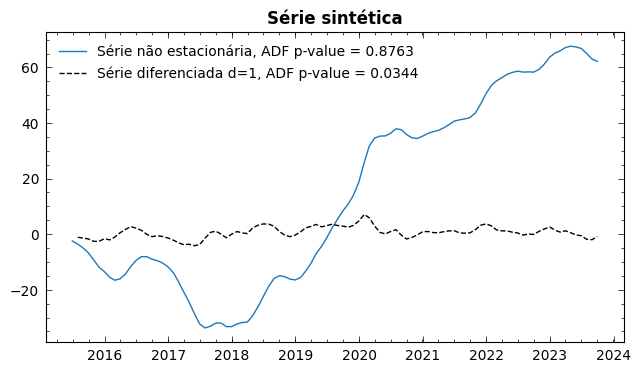

In [ ]:
plt.plot(ts, label = 'Série não estacionária, ADF p-value = ' + str(np.round(adfuller(ts)[1],4)))
plt.plot(ts.diff(), 'k--', label = 'Série diferenciada d=1, ADF p-value = ' + str(np.round(adfuller(ts.diff().dropna())[1],4)))

plt.legend()
plt.title('Série sintética')
plt.show()


### 3.4.2. Verificação da autocorrelação e autocorrelação parcial da série

Os parâmetros $p$ e $q$ são obtidos respectivamente da análise dos gráficos de autocorrelação parcial e autocorrelação, e obtemos assim os valores $p=3$ e $q=3$.

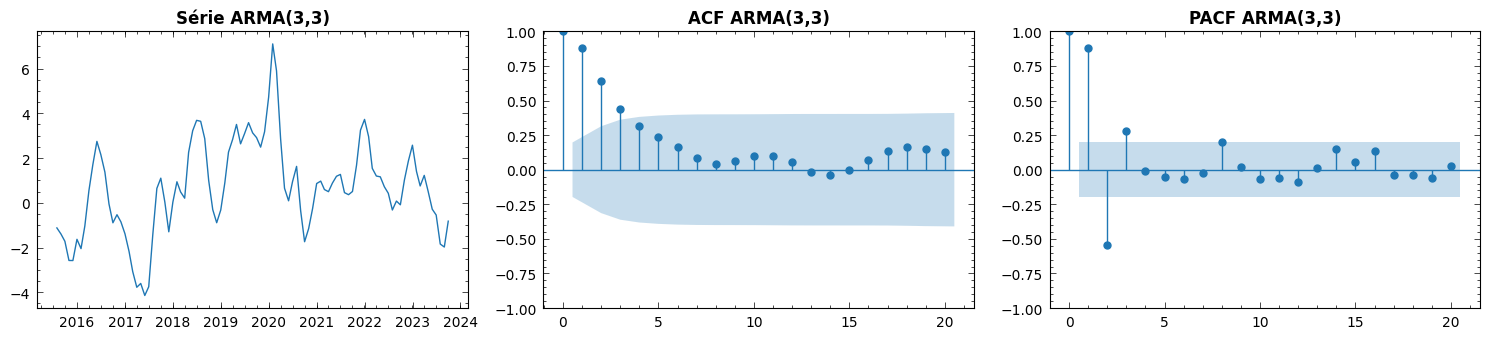

In [ ]:
plot_ts_acf_pacf(ts.diff().dropna(),'ARMA(3,3)')

### 3.4.3. Análise dos modelos e seleção dos parâmetros

Podemos então aplicar esses parâmetros e analisar o ajuste da série e métricas do modelo obtido.

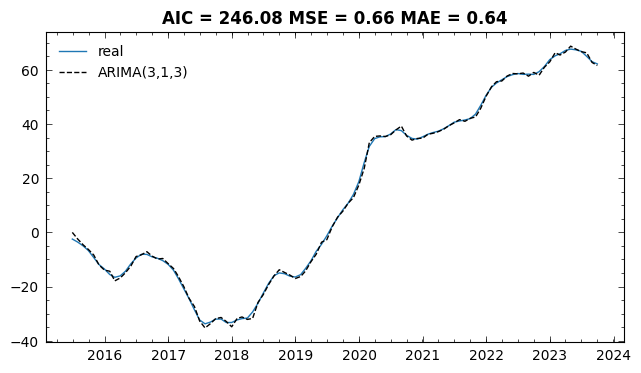

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p = 3; d = 1; q = 3
model = ARIMA(ts, order=(p, d, q))
results = model.fit(method_kwargs={'maxiter':700})

plt.plot(ts,label='real')
plt.plot(results.fittedvalues, 'k--', label='ARIMA(' + str(p) + ',' + str(d) + ',' + str(q) + ')')
plt.title(f'AIC = {results.aic:.2f} MSE = {results.mse:.2f} MAE = {results.mae:.2f}')

plt.legend()
plt.show()

O sumário do `statsmodels` fornece uma série de informações para análise do modelo.

In [ ]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -116.041
Date:                Fri, 12 Jan 2024   AIC                            246.083
Time:                        17:09:45   BIC                            264.248
Sample:                    06-30-2015   HQIC                           253.432
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4131      0.357      3.955      0.000       0.713       2.113
ar.L2         -1.2381      0.399     -3.106      0.002      -2.019      -0.457
ar.L3          0.6095      0.198      3.072      0.0

Ele consiste de 3 partes. Na primeira parte há informações gerais do modelo, como ordem do modelo, número de amostras e métricas como o AIC e BIC. Na segunda, há os coeficientes estimados, sua significância e intervalo de confiança. A terceira parte traz indicadores para análise dos resíduos.

Os gráficos das funções PACF e ACF sugerem valores de $p$ e $q$ a serem empregados. Mas podemos buscar alguma métrica de desempenho do modelo, como uma métrica de erro ou o AIC, para busca dos melhores parâmetros.

In [ ]:
warnings.filterwarnings('ignore')
model_list = []; AIC_list = []

d = 1
for p in range(2,5):
  for q in range(2,5):
    model = ARIMA(ts, order=(p, d, q))
    results = model.fit(method_kwargs={'maxiter':700})
    model_list.append('ARIMA(' + str(p) + ',' + str(d) + ',' + str(q) + ')')
    AIC_list.append(np.round(results.aic,4))

results_df = pd.DataFrame({'model': model_list, 'AIC': np.array(AIC_list) }).sort_values('AIC',ascending=False)
display(results_df)

warnings.filterwarnings('ignore')

,model,AIC
2,"ARIMA(2,1,4)",248.3544
6,"ARIMA(4,1,2)",247.5014
1,"ARIMA(2,1,3)",247.3347
4,"ARIMA(3,1,3)",246.0826
3,"ARIMA(3,1,2)",246.0429
8,"ARIMA(4,1,4)",245.6695
0,"ARIMA(2,1,2)",245.4423
5,"ARIMA(3,1,4)",245.4241
7,"ARIMA(4,1,3)",244.4067


Assim, para o melhor desempenho pela métrica AIC podemos escolher os valores $p = 2, d = 1, q = 4$ e, então, analisar se os erros obtidos satisfazem as premissas do modelo.

In [ ]:
p = 2; d = 1; q = 4
model = ARIMA(ts, order=(p, d, q))
results = model.fit(method_kwargs={'maxiter':700})
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -117.177
Date:                Fri, 12 Jan 2024   AIC                            248.354
Time:                        17:09:49   BIC                            266.520
Sample:                    06-30-2015   HQIC                           255.704
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4308      0.556      2.574      0.010       0.341       2.520
ar.L2         -0.4610      0.464     -0.994      0.320      -1.370       0.448
ma.L1          0.0946      0.562      0.168      0.8

### 3.4.4. Análise dos resíduos

Na parte dos indicadores de resíduos os valores `Prob` correspondem a p-valores das métricas indicadas (no exemplo, p-value Ljung-Box = 0.92 > 0.05 indica que os resíduos são ruído branco e p-value Jarque-Bera = 0.66 > 0.05 indica que os resíduos tem uma distribuição normal).

A análise dos resíduos ainda é normalmente complementada com análise dos gráficos da função `plot_diagnostics()` para, além da normalidade, verificarmos a independência dos valores de erro. No exemplo, como podemos ver, os erros não estão corelacionados.

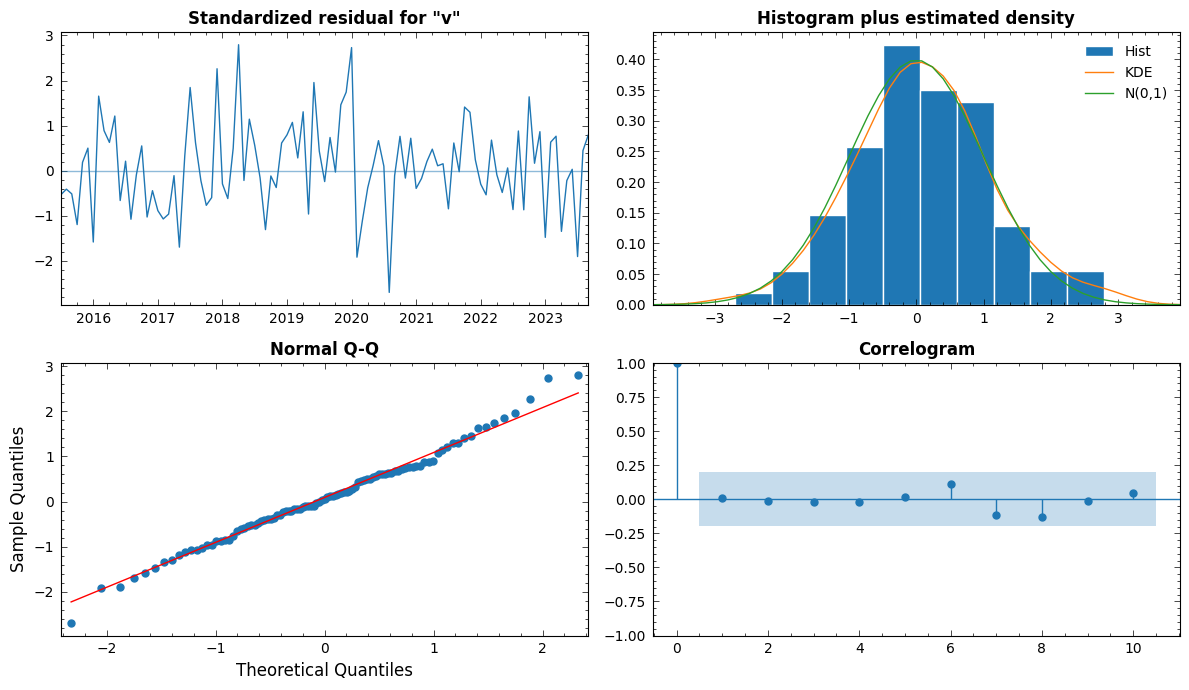

In [ ]:
fig = plt.figure(figsize=(12,7))

results.plot_diagnostics(fig=fig)

plt.tight_layout()
plt.show()

### 3.4.5. Previsões

Uma vez selecionado o modelo podemos fazer previsões de valores futuros da série. Por exemplo, a predição para os próximos 6 meses.


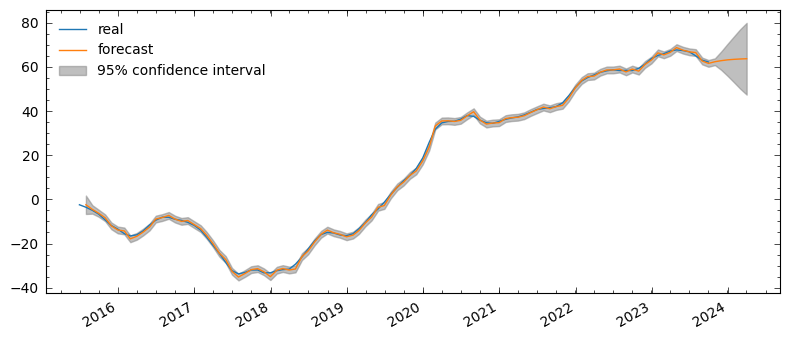

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(ts,label='real')
plot_predict(results, start=pd.to_datetime('2015-07-31'), end=pd.to_datetime('2024-03-31'),ax=ax) # alerta: start deve ser ao menos d períodos a frente do início da série
# plot_predict(results, start=1, end=len(ts) + 6,ax=ax) # aqui, funciona o mesmo modo

plt.tight_layout()
plt.show()

In [ ]:
results.forecast(6)

2023-10-31    62.313898
2023-11-30    62.791316
2023-12-31    63.171009
2024-01-31    63.401228
2024-02-29    63.555601
2024-03-31    63.670354
Freq: M, Name: predicted_mean, dtype: float64

# **4. Aprendizado de máquina**

Os modelos autoregressivos, como vimos, baseiam-se em modelos de regressão linear. Modelos de aprendizado de máquina supervisionado também podem ser empregados para fazer previsões de valores futuros de séries temporais e têm tido um sucesso grande em fornecer previsões mais precisas para séries muito complexas, em particular modelos baseados em redes neurais profundas desenvolvidas com `PyTorch` ou `TensorFlow/Keras`, ou modelos híbridos como o Greykite (2021) (LinkedIn) e Prophet (2021) (Meta). As diferenças entre um modelo estatístico e um modelo de aprendizado de máquina residem na capacidade de precisão e explicabilidade de cada modelo e, de modo bastante simples, poderíamos dizer que trata-se de uma escolha entre fazer previsão mais precisa (modelos de aprendizado de máquina) ou compreender os processos subjacentes aos dados (modelos estatísticos), não excluindo o caso em que ambas as técnicas podem ser aplicadas.  

Independente se empregamos um modelo de aprendizado de máquina clássico (como regressores de árvores de decisão, florestas de árvores aleatórias e k-vizinhos mais próximos)
ou de redes neurais, incluindo aprendizado profundo (*deep learning*), o processo é bastante semelhante partindo por empregar os valores defasados da série como variáveis preditoras (como vimos no modelo autoregressivo anteriormente). Este processo está representado na figura 2.








<img src="https://github.com/Rogerio-mack/SBSI_2024_ts_short_course/blob/main/figures/ML_ts.png?raw=true" width=800>

**Figura 2. Esquema geral do aprendizado de máquina (regressão) e da engenharia de atributos para séries temporais.**

Em todos os casos, dado uma classe de modelos que desejamos empregar para aproximar uma série, o modelo é ajustado até que se alcance um erro mínimo por alguma métrica (como o MSE). Diferentemente de um modelo estatístico, como o ARIMA, a aplicação do modelo de não requer nenhum pressuposto como estacionariedade, não sazonalidade ou independência e normalidade dos resíduos, sendo seu único objetivo aproximar ao máximo a série que se deeja modelar. Esse aspecto de *caixa-preta* ou de *força-bruta*, principalmente nos modelos de aprendizado profundo, é uma das principais críticas na aplicação desses tipo de modelo em séries temporais. Entretanto, eles podem obter resultados de previsibilidade bastante bons em casos muito complexos.

São inúmeras as classes de modelos e bibliotecas disponíveis. Mas sendo o esquema geral de aplicação do método o mesmo, vamos apresentar uma aplicação com modelos clássicos de aprendizado empregando o pacote `scikit-learn` e outra de aprendizado profundo, com `TensorFlow/Keras`, o que para os nossos propósitos parece ser suficiente.

## 4.1. Scikit-learn

O `scikit-learn` é a principal biblioteca de aprendizado de máquina de modelos clássicos (não profundo), incluindo modelos de aprendizado supervisionado (classificação, regressão) e não supervisionado (clusterização, detecção de anomalias, redução de dimensionalidade). Para predição de séries temporais empregamos modelos regressores e uma relação dos modelos disponíveis encontram-se a seguir.

In [ ]:
# alguns dos estimadores de regressão disponíveis no scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error

Cada um desses modelos tem um *princípio*, ou fundamento, mas que não entraremos em detalhe aqui. Assim, um estimador como `MLPRegressor` empregará uma rede neural para aproximar uma série, enquanto um `DecisionTreeRegressor` empregará uma árvore de decisão baseada na distribuição dos valores. Quaisquer desses estimadores podem ser igualmente aplicados.

### 4.1.1. Exemplo

Vamos empregar a série `co2` utilizada antes. Já criamos os dados defasados da série para serem as variáveis preditoras do modelos. Desse modo, faremos fazer o ajuste do modelo para,

$$ (CO2_{t-1},CO2_{t-2}) \longrightarrow CO2_t $$

In [ ]:
df = co2
df.head()

,time,CO2,CO2_t-1,CO2_t-2
Date,,,,
1981-07-01,2,340.32,342.08,342.74
1981-08-01,3,338.26,340.32,342.08
1981-09-01,4,336.52,338.26,340.32
1981-10-01,5,336.68,336.52,338.26
1981-11-01,6,338.19,336.68,336.52


Um conceito importante na construção de modelos de aprendizado de máquina é o conceito de **conjuntos de treinamento e teste**. A ideia é separar dados empregados para o treinamento do modelo daqueles que são empregados para mensurar o seu desempenho. Há várias formas de fazer isso e, tipicamente, são empregados um percentual de dados aleatórios para treinamento (80% por exemplo) e teste (20%). Mas uma alternativa ao tratarmos de séries temporais considerarmos para teste os dados mais recentes (por exemplo, os 20% que correspondem aos dados mais recentes).


          

In [ ]:
# Criando conjuntos de dados para treinamento e teste
train_size = int(len(df) * 0.80)
train_data, test_data = df.iloc[0:train_size], df.iloc[train_size:len(df)]

O código a seguir é um padrão para o uso de estimadores do `scikit-learn` e o estimador (modelo) empregado a seguir pode ser substituído por quaisquer dos outros regressores disponíveis.

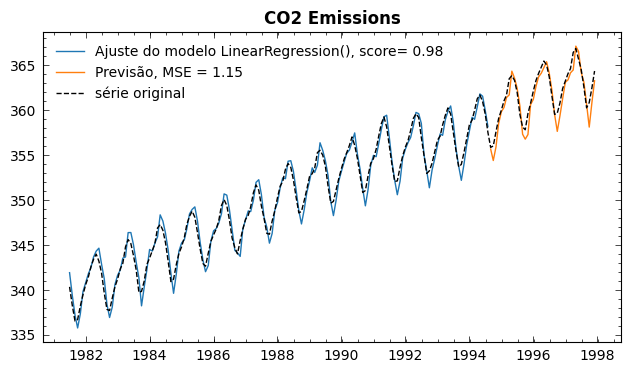

In [ ]:
X_train, y_train, X_test, y_test = train_data[['CO2_t-1','CO2_t-2']], train_data[['CO2']], test_data[['CO2_t-1','CO2_t-2']], test_data[['CO2']]

model = LinearRegression()
# model = DecisionTreeRegressor() # try this!

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.plot(df.iloc[0:train_size].index, model.predict(X_train),label='Ajuste do modelo ' + str(model) + ', score= ' + str(np.round(model.score(X_train,y_train),2)))
plt.plot(df.iloc[train_size:len(df)].index, y_pred,label='Previsão, MSE = ' + str(np.round(mean_squared_error(y_test, y_pred),2)))
plt.plot(df.CO2,'k--',label='série original',lw=1)

plt.legend(loc='upper left',fontsize=10)
plt.title('CO2 Emissions')

plt.show()

In [ ]:
df = pd.read_csv(path + 'dados_bike.csv',index_col=0,parse_dates=True)

df = df[ (df.index.month <= 6) & (df.index.month >= 2)  ]

df['cnt_t-1'] = df['cnt'].shift()
df['cnt_t-2'] = df['cnt'].shift(2)
df = df.dropna()
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,cnt_t-1,cnt_t-2
timestamp,,,,,,,,,,,,
2015-02-03,2972,4.0,1.0,93.0,17.5,26.0,0.0,0.0,3.0,2015,3556.0,1117.0
2015-02-04,3502,5.0,2.0,93.0,19.0,7.0,0.0,0.0,3.0,2015,2972.0,3556.0
2015-02-05,2894,5.0,2.0,93.0,21.0,26.0,0.0,0.0,3.0,2015,3502.0,2972.0
2015-02-06,3214,5.0,1.0,84.0,27.0,4.0,0.0,0.0,3.0,2015,2894.0,3502.0
2015-02-07,1165,6.0,3.5,87.0,16.0,4.0,0.0,1.0,3.0,2015,3214.0,2894.0


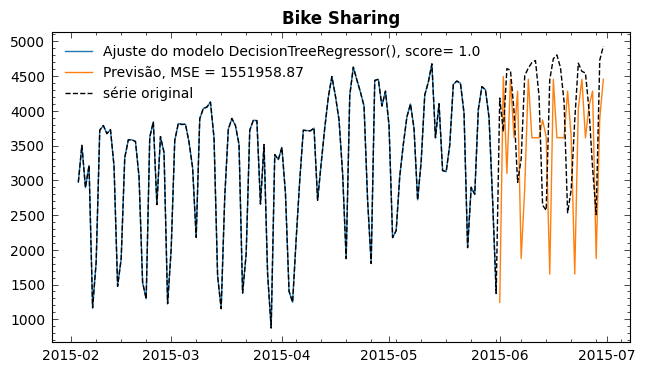

In [ ]:
# Criando conjuntos de dados para treinamento e teste
train_size = int(len(df) * 0.80)
train_data, test_data = df.iloc[0:train_size], df.iloc[train_size:len(df)]

X_train, y_train, X_test, y_test = train_data[['cnt_t-1','cnt_t-2']], train_data[['cnt']], test_data[['cnt_t-1','cnt_t-2']], test_data[['cnt']]

model = LinearRegression()
model = DecisionTreeRegressor() # try this!

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.plot(df.iloc[0:train_size].index, model.predict(X_train),label='Ajuste do modelo ' + str(model) + ', score= ' + str(np.round(model.score(X_train,y_train),2)))
plt.plot(df.iloc[train_size:len(df)].index, y_pred,label='Previsão, MSE = ' + str(np.round(mean_squared_error(y_test, y_pred),2)))
plt.plot(df.cnt,'k--',label='série original',lw=1)

plt.legend(loc='upper left',fontsize=10)
plt.title('Bike Sharing')

plt.show()

In [ ]:
_ = error_measures(y_test.values.flatten(), y_pred.flatten())

MSE: 	 1551958.8667
MAE: 	 1024.0667
RMSE: 	 1245.7764
MAPE: 	 0.2733


## 4.2. TensorFlow/Keras

O `TensorFlow` é uma biblioteca para a implementação de aprendizado profundo que permite criar modelos bastante complexos e uso de recursos de processamento em gpu, e o `Keras` fornece uma interface de mais alto nível para sua programação. Diferentes tipos de redes podem ser empregados e vamos empregar aqui dois modelos, um modelo de camadas sequenciais (ou rede multilayer perceptron) e um modelo LSTM (long short-term memory) que é uma arquitetura de rede neural recorrente bastante empregados em modelos de séries temporais.

### 4.2.1. Exemplo

Empregamos os mesmos dados de Bike Sharing do exemplo anterior. Em um modelo neural é comum normalizarmos os dados (que são desnormalizados na previsão dos valores).

In [ ]:
data = pd.read_csv(path + 'dados_bike.csv',index_col=0,parse_dates=True)

data = data[ (data.index.month <= 6) & (data.index.month >= 2) ]
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year
timestamp,,,,,,,,,,
2015-02-01,1117,6.0,1.5,87.0,34.0,26.0,0.0,1.0,3.0,2015
2015-02-02,3556,3.0,-0.5,70.0,17.0,2.0,0.0,0.0,3.0,2015
2015-02-03,2972,4.0,1.0,93.0,17.5,26.0,0.0,0.0,3.0,2015
2015-02-04,3502,5.0,2.0,93.0,19.0,7.0,0.0,0.0,3.0,2015
2015-02-05,2894,5.0,2.0,93.0,21.0,26.0,0.0,0.0,3.0,2015


In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df = data[['cnt']]

# Normalizando os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df['cnt'] = scaler.fit_transform(df)

df['cnt_t-1'] = df['cnt'].shift()
df['cnt_t-2'] = df['cnt'].shift(2)
# df['cnt_t-3'] = df['cnt'].shift(3)
# df['cnt_t-4'] = df['cnt'].shift(4)
# df[['hum', 'wind_speed', 'weather_code', 'is_weekend', 'season']] = data[['hum', 'wind_speed', 'weather_code', 'is_weekend', 'season']]

df = df.dropna()

# Criando conjuntos de dados para treinamento e teste
train_size = int(len(df) * 0.80)
train_data, test_data = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# X_train, y_train, X_test, y_test = train_data[['cnt_t-1','cnt_t-2']], train_data[['cnt']], test_data[['cnt_t-1','cnt_t-2']], test_data[['cnt']]
X_train, y_train, X_test, y_test = train_data.drop(columns='cnt'), train_data[['cnt']], test_data.drop(columns='cnt'), test_data[['cnt']]

In [ ]:
def model_builder_MLP(hp):

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 16-128

  # model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  # model.add(LSTM(units=10))

  hp_units_1 = hp.Int('hp_units_1', min_value=16, max_value=64, step=8)
  model = keras.Sequential()
  # model.add(LSTM(units=hp_units_1, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(layers.Dense(units=hp_units_1, activation='relu', input_shape=[X_train.shape[1]]))

  # Tune the number of hidden layers 2-10 and units per layer
  for i in range(hp.Int('num_layers', 1, 4)):

    model.add(Dropout(0.05))
    model.add(layers.Dense(units=hp.Int('hp_units_' + str(i),
                                            min_value=16,
                                            max_value=64,
                                            step=8)))

    #model.add(layers.Dense(units=hp.Int('hp_units_' + str(i),
    #                                        min_value=64,
    #                                        max_value=512,
    #                                        step=32),
    #                          activation='relu'))

  model.add(layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(keras.optimizers.Adam(),
                loss='mean_squared_error',
                metrics='mean_squared_error')

  return model

In [ ]:
def model_builder_LSTM(hp):

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 16-128

  # model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  # model.add(LSTM(units=10))

  hp_units_1 = hp.Int('hp_units_1', min_value=128, max_value=1024, step=128)
  model = keras.Sequential()
  model.add(LSTM(units=hp_units_1, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  # model = keras.Sequential(layers.Dense(units=hp_units_1, activation='relu', input_shape=[X_train.shape[1]]))

  # Tune the number of hidden layers 2-10 and units per layer
  for i in range(hp.Int('num_layers', 1, 3)):

    model.add(Dropout(0.10))
    model.add(LSTM(units=hp.Int('hp_units_' + str(i),
                                            min_value=128,
                                            max_value=1024,
                                            step=128),
                                            return_sequences=True))

    #model.add(layers.Dense(units=hp.Int('hp_units_' + str(i),
    #                                        min_value=64,
    #                                        max_value=512,
    #                                        step=32),
    #                          activation='relu'))

  hp_units_2 = hp.Int('hp_units_2', min_value=128, max_value=1024, step=128)
  model.add(LSTM(units=hp_units_2))
  model.add(layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(keras.optimizers.Adam(),
                loss='mean_squared_error',
                metrics='mean_squared_error')

  return model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, layers
import tensorflow as tf
from keras.layers import Dropout

tuner = kt.Hyperband(model_builder_LSTM,
# tuner = kt.Hyperband(model_builder_MLP,
                     objective='mean_squared_error',
                     max_epochs=50,
                     factor=3,
                     directory='mydir',
                     project_name='sbsc_course')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

tuner.search(X_train, y_train,
             batch_size=32,
             epochs=50,
             validation_split=0.2,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 17 Complete [00h 00m 18s]
mean_squared_error: 0.279123991727829

Best mean_squared_error So Far: 0.10481677949428558
Total elapsed time: 00h 06m 00s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
1024              |640               |hp_units_1
3                 |1                 |num_layers
384               |1024              |hp_units_0
640               |1024              |hp_units_2
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


KeyboardInterrupt: 

In [ ]:
# print(f"""
# The hyperparameter search is complete.

# The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
# """)

print('Best layers units: \n')
for i in range(2,6):
  print('Layer: ', i-1, ' , ', best_hps.get('hp_units_' + str(i)), ' units')

Best layers units: 

Layer:  1  ,  192  units


KeyError: 'hp_units_3 does not exist.'

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train,
               batch_size=64,
               epochs=10,
               validation_split=0.2)

model = hypermodel

# Predição com o modelo treinado
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertendo a escala de normalização
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

_ = error_measures(y_test.values.flatten(), test_predict.flatten())

Epoch 1/10
5/5 [==============================] - 4s 109ms/step - loss: 0.1567 - mean_squared_error: 0.1567 - val_loss: 0.1044 - val_mean_squared_error: 0.1044
Epoch 2/10
5/5 [==============================] - 0s 17ms/step - loss: 0.0727 - mean_squared_error: 0.0727 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 3/10
5/5 [==============================] - 0s 27ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 4/10
5/5 [==============================] - 0s 22ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 5/10
5/5 [==============================] - 0s 22ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 7/10
5/5 [=============================

Epoch 1/50
8/8 [==============================] - 10s 12ms/step - loss: 0.3098
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.1321
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0602
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0602
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0496
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0491
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0487
Epoch 8/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0484
Epoch 9/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0497
Epoch 10/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0478
Epoch 11/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0484
Epoch 12/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0471
Epoch 13/50
8/8 [==============================] - 0s 12ms/s

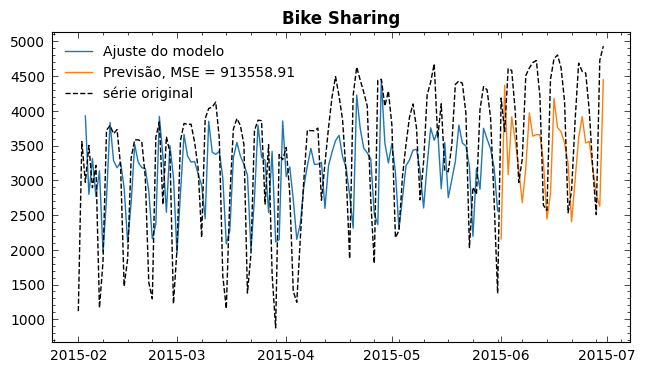

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = data[['cnt']]

# Normalizando os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df['cnt'] = scaler.fit_transform(df)

df['cnt_t-1'] = df['cnt'].shift()
df['cnt_t-2'] = df['cnt'].shift(2)
# df['cnt_t-3'] = df['cnt'].shift(3)
# df['cnt_t-4'] = df['cnt'].shift(4)
# df[['hum', 'wind_speed', 'weather_code', 'is_weekend', 'season']] = data[['hum', 'wind_speed', 'weather_code', 'is_weekend', 'season']]

df = df.dropna()

# Criando conjuntos de dados para treinamento e teste
train_size = int(len(df) * 0.80)
train_data, test_data = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# X_train, y_train, X_test, y_test = train_data[['cnt_t-1','cnt_t-2']], train_data[['cnt']], test_data[['cnt_t-1','cnt_t-2']], test_data[['cnt']]
X_train, y_train, X_test, y_test = train_data.drop(columns='cnt'), train_data[['cnt']], test_data.drop(columns='cnt'), test_data[['cnt']]

# Criando o modelo LSTM
model = Sequential()

# it works MAPE = 0.14
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))

# it works MAPE = 0.16
# model.add(LSTM(units=1024, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# model.add(LSTM(units=32))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=0)

# Predição com o modelo treinado
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertendo a escala de normalização
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_test = scaler.inverse_transform(y_test)

plt.plot(df.iloc[0:train_size].index, train_predict,label='Ajuste do modelo ')
plt.plot(df.iloc[train_size:len(df)].index, test_predict,label='Previsão, MSE = ' + str(np.round(mean_squared_error(y_test, test_predict),2)))
plt.plot(data.cnt,'k--',label='série original',lw=1)

plt.legend(loc='upper left',fontsize=10)
plt.title('Bike Sharing')

plt.show()


In [ ]:
_ = error_measures(y_test.flatten(), test_predict.flatten())

MSE: 	 913558.9124
MAE: 	 813.5970
RMSE: 	 955.8028
MAPE: 	 0.1962


# **6. Conclusão**

A ferramenta certa - aprendizado de máquina ou estatística clássica − em última análise, depende do contexto de negócios mais amplo para sua análise.

# **Referências**

Greykite (2021). https://engineering.linkedin.com/blog/2021/greykite--a-flexible--intuitive--and-fast-forecasting-library

Prophet (2021). https://facebook.github.io/prophet/

